# Defining DataLoader

In [29]:
from skimage import io
img = io.imread('/kaggle/input/marida-m/patches/S2_1-12-19_48MYU/S2_1-12-19_48MYU_0.tif')
mask = io.imread('/kaggle/input/marida-m/patches/S2_1-12-19_48MYU/S2_1-12-19_48MYU_0_cl.tif')
print(img.shape)
print(mask.shape)
print(img.dtype)
mask = mask.astype('int64')
print(mask.dtype)


(256, 256, 11)
(256, 256)
float32
int64


In [30]:
# -*- coding: utf-8 -*-


import os
import torch
import random
import numpy as np
from tqdm import tqdm
#from osgeo import gdal
from skimage import io
from os.path import dirname as up
from torch.utils.data import Dataset
import torchvision.transforms.functional as F

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Pixel-Level class distribution (total sum equals 1.0)
class_distr = torch.Tensor([0.00452, 0.00203, 0.00254, 0.00168, 0.00766, 0.15206, 0.20232,
 0.35941, 0.00109, 0.20218, 0.03226, 0.00693, 0.01322, 0.01158, 0.00052])

bands_mean = np.array([0.05197577, 0.04783991, 0.04056812, 0.03163572, 0.02972606, 0.03457443,
 0.03875053, 0.03436435, 0.0392113,  0.02358126, 0.01588816]).astype('float32')

bands_std = np.array([0.04725893, 0.04743808, 0.04699043, 0.04967381, 0.04946782, 0.06458357,
 0.07594915, 0.07120246, 0.08251058, 0.05111466, 0.03524419]).astype('float32')

###############################################################
# Pixel-level Semantic Segmentation Data Loader               #
###############################################################
#dataset_path = os.path.join(up(up(up(__file__))), 'data')
dataset_path = '/kaggle/input/marida-m/'

class GenDEBRIS(Dataset): # Extend PyTorch's Dataset class
    def __init__(self, mode = 'train', transform=None, standardization=None, path = dataset_path, agg_to_water= True):
        
        if mode=='train':
            self.ROIs = np.genfromtxt(os.path.join(path, 'splits', 'train_X.txt'),dtype='str')
                
        elif mode=='test':
            self.ROIs = np.genfromtxt(os.path.join(path, 'splits', 'test_X.txt'),dtype='str')
                
        elif mode=='val':
            self.ROIs = np.genfromtxt(os.path.join(path, 'splits', 'val_X.txt'),dtype='str')
            
        else:
            raise
            
        self.X = []           # Loaded Images
        self.y = []           # Loaded Output masks
            
        for roi in tqdm(self.ROIs, desc = 'Load '+mode+' set to memory'):
            
            # Construct file and folder name from roi
            roi_folder = '_'.join(['S2'] + roi.split('_')[:-1])               # Get Folder Name
            roi_name = '_'.join(['S2'] + roi.split('_'))                      # Get File Name
            roi_file = os.path.join(path, 'patches', roi_folder,roi_name + '.tif')       # Get File path
            roi_file_cl = os.path.join(path, 'patches', roi_folder,roi_name + '_cl.tif') # Get Class Mask
            
            # Load Classsification Mask
            #ds = gdal.Open(roi_file_cl)
            #temp = np.copy(ds.ReadAsArray().astype(np.int64))
            ds = io.imread(roi_file_cl)
            temp = np.copy(ds.astype(np.int64))
            # Aggregation
            if agg_to_water:
                temp[temp==15]=7          # Mixed Water to Marine Water Class
                temp[temp==14]=7          # Wakes to Marine Water Class
                temp[temp==13]=7          # Cloud Shadows to Marine Water Class
                temp[temp==12]=7          # Waves to Marine Water Class
            
            # Categories from 1 to 0
            temp = np.copy(temp - 1)
            ds=None                   # Close file
            
            self.y.append(temp)
            
            # Load Patch
            #ds = gdal.Open(roi_file)
            #temp = np.copy(ds.ReadAsArray())
            ds = io.imread(roi_file)
            #ds = np.moveaxis(ds,[0,1,2],[2,0,1])
            temp = np.copy(ds)
            ds=None
            self.X.append(temp)          

        self.impute_nan = np.tile(bands_mean, (temp.shape[0],temp.shape[1],1))
        self.mode = mode
        self.transform = transform
        self.standardization = standardization
        self.length = len(self.y)
        self.path = path
        self.agg_to_water = agg_to_water
        
    def __len__(self):

        return self.length
    
    def getnames(self):
        return self.ROIs
    
    def __getitem__(self, index):
        
        img = self.X[index]
        target = self.y[index]
        
        #img = np.moveaxis(img, [0, 1, 2], [2, 0, 1]).astype('float32')       # CxWxH to WxHxC
        
        #self.impute_nan = np.moveaxis(self.impute_nan, [0, 1, 2], [2, 0, 1]).astype('float32')       # CxWxH to WxHxC
        
        nan_mask = np.isnan(img)
        img[nan_mask] = self.impute_nan[nan_mask]
        
        if self.transform is not None:
            target = target[:,:,np.newaxis]
            stack = np.concatenate([img, target], axis=-1).astype('float32') # In order to rotate-transform both mask and image
        
            stack = self.transform(stack)

            img = stack[:-1,:,:]
            target = stack[-1,:,:].long()                                    # Recast target values back to int64 or torch long dtype
        
        if self.standardization is not None:
            img = self.standardization(img)
            
        return img, target
    
###############################################################
# Transformations                                             #
###############################################################
class RandomRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return F.rotate(x, angle)
    
###############################################################
# Weighting Function for Semantic Segmentation                #
###############################################################
def gen_weights(class_distribution, c = 1.02):
    return 1/torch.log(c + class_distribution)

# Defining U-net ++ (not working)

In [31]:
# import torch
# from torch import nn

# class NestedUNet(nn.Module):
#     def __init__(self, input_bands=11, output_classes=11, hidden_channels=16):
#         super(NestedUNet, self).__init__()
#         self.hidden_channels = hidden_channels

#         def double_conv(in_channels, out_channels):
#             return nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True)
#             )

#         # Contracting path (same as UNet)
#         self.conv0_0 = double_conv(input_bands, hidden_channels)
#         self.conv1_0 = double_conv(hidden_channels, hidden_channels * 2)
#         self.conv2_0 = double_conv(hidden_channels * 2, hidden_channels * 4)
#         self.conv3_0 = double_conv(hidden_channels * 4, hidden_channels * 8)
#         self.conv4_0 = double_conv(hidden_channels * 8, hidden_channels * 8)

#         # Expanding path (matching UNet)
#         self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.conv3_1 = double_conv(hidden_channels * 8 + hidden_channels * 8, hidden_channels * 8)

#         self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.conv2_2 = double_conv(hidden_channels * 4 + hidden_channels * 8, hidden_channels * 4)

#         self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.conv1_3 = double_conv(hidden_channels * 2 + hidden_channels * 4, hidden_channels * 2)

#         self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.conv0_4 = double_conv(hidden_channels + hidden_channels * 2, hidden_channels)

#         # Final output layer
#         self.final = nn.Conv2d(hidden_channels, output_classes, kernel_size=1)

#     def forward(self, x):
#         # Contracting path
#         x0_0 = self.conv0_0(x)
#         x1_0 = self.conv1_0(self.up1(x0_0))
#         x2_0 = self.conv2_0(self.up2(x1_0))
#         x3_0 = self.conv3_0(self.up3(x2_0))
#         x4_0 = self.conv4_0(self.up4(x3_0))

#         # Expanding path (matching UNet)
#         x3_1 = self.conv3_1(torch.cat([x3_0, self.up1(x4_0)], dim=1))
#         x2_2 = self.conv2_2(torch.cat([x2_0, self.up2(x3_1)], dim=1))
#         x1_3 = self.conv1_3(torch.cat([x1_0, self.up3(x2_2)], dim=1))
#         x0_4 = self.conv0_4(torch.cat([x0_0, self.up4(x1_3)], dim=1))

#         # Final output
#         output = self.final(x0_4)
#         return output


In [32]:
# import torch
# from torch import nn

# class NestedUNet(nn.Module):
#     def __init__(self, input_bands=11, output_classes=11, hidden_channels=16):
#         super(NestedUNet, self).__init__()
#         self.hidden_channels = hidden_channels

#         def double_conv(in_channels, out_channels):
#             return nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True)
#             )

#         # Contracting path
#         self.conv0_0 = double_conv(input_bands, hidden_channels)
#         self.conv1_0 = double_conv(hidden_channels, hidden_channels * 2)
#         self.conv2_0 = double_conv(hidden_channels * 2, hidden_channels * 4)
#         self.conv3_0 = double_conv(hidden_channels * 4, hidden_channels * 8)
#         self.conv4_0 = double_conv(hidden_channels * 8, hidden_channels * 8)

#         # Expanding path (nested convolutions)
#         self.conv0_1 = double_conv(hidden_channels + hidden_channels * 2, hidden_channels)
#         self.conv1_1 = double_conv(hidden_channels * 2 + hidden_channels * 4, hidden_channels * 2)
#         self.conv2_1 = double_conv(hidden_channels * 4 + hidden_channels * 8, hidden_channels * 4)
#         self.conv3_1 = double_conv(hidden_channels * 8 + hidden_channels * 8, hidden_channels * 8)

#         self.conv0_2 = double_conv(hidden_channels * 2 + hidden_channels, hidden_channels)
#         self.conv1_2 = double_conv(hidden_channels * 4 + hidden_channels * 2, hidden_channels * 2)
#         self.conv2_2 = double_conv(hidden_channels * 8 + hidden_channels * 4, hidden_channels * 4)

#         self.conv0_3 = double_conv(hidden_channels * 3 + hidden_channels, hidden_channels)
#         self.conv1_3 = double_conv(hidden_channels * 6 + hidden_channels * 2, hidden_channels * 2)

#         self.conv0_4 = double_conv(hidden_channels * 4 + hidden_channels, hidden_channels)

#         # Up-sampling layers
#         self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#         # Final output layer
#         self.final = nn.Conv2d(hidden_channels, output_classes, kernel_size=1)

#     def forward(self, x):
#         # Contracting path
#         x0_0 = self.conv0_0(x)
#         x1_0 = self.conv1_0(self.up(x0_0))
#         x2_0 = self.conv2_0(self.up(x1_0))
#         x3_0 = self.conv3_0(self.up(x2_0))
#         x4_0 = self.conv4_0(self.up(x3_0))

#         # Nested path
#         x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], dim=1))
#         x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], dim=1))
#         x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], dim=1))
#         x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], dim=1))

#         x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], dim=1))
#         x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], dim=1))
#         x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], dim=1))

#         x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], dim=1))
#         x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], dim=1))

#         x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], dim=1))

#         # Final output layer
#         output = self.final(x0_4)
#         return output


# Defining Residual Unet

In [33]:
# -*- coding: utf-8 -*-

import torch
from torch import nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels))

        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = self.residual(x)
        x = self.conv(x)
        return nn.ReLU(inplace=True)(x + residual)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.res_block = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.maxpool(x)
        return self.res_block(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.res_block = ResidualBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.res_block(x)

class ResidualUNet(nn.Module):
    def __init__(self, input_bands=11, output_classes=11, hidden_channels=16):
        super(ResidualUNet, self).__init__()

        # Initial Convolution Layer
        self.inc = ResidualBlock(input_bands, hidden_channels)

        # Contracting Path
        self.down1 = Down(hidden_channels, 2 * hidden_channels)
        self.down2 = Down(2 * hidden_channels, 4 * hidden_channels)
        self.down3 = Down(4 * hidden_channels, 8 * hidden_channels)
        self.down4 = Down(8 * hidden_channels, 8 * hidden_channels)

        # Expanding Path
        self.up1 = Up(16 * hidden_channels, 4 * hidden_channels)
        self.up2 = Up(8 * hidden_channels, 2 * hidden_channels)
        self.up3 = Up(4 * hidden_channels, hidden_channels)
        self.up4 = Up(2 * hidden_channels, hidden_channels)

        # Output Convolution Layer
        self.outc = nn.Conv2d(hidden_channels, output_classes, kernel_size=1)

    def forward(self, x):
        # Contracting Path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Expanding Path
        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)

        # Output Convolution Layer
        logits = self.outc(x9)
        return logits

# Defining Attention U-Net

In [34]:
import torch
from torch import nn

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, g, x):
        # Align spatial dimensions if necessary
        if g.size() != x.size():
            g = self.upsample(g)

        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class AttentionUNet(nn.Module):
    def __init__(self, input_bands=1, output_classes=1, hidden_channels=64):
        super(AttentionUNet, self).__init__()
        # Initial Convolution Layer
        self.inc = nn.Sequential(
            nn.Conv2d(input_bands, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )

        # Contracting Path
        self.down1 = Down(hidden_channels, hidden_channels * 2)
        self.down2 = Down(hidden_channels * 2, hidden_channels * 4)
        self.down3 = Down(hidden_channels * 4, hidden_channels * 8)
        self.down4 = Down(hidden_channels * 8, hidden_channels * 8)

        # Expanding Path
        self.up1 = Up(hidden_channels * 16, hidden_channels * 4)
        self.up2 = Up(hidden_channels * 8, hidden_channels * 2)
        self.up3 = Up(hidden_channels * 4, hidden_channels)
        self.up4 = Up(hidden_channels * 2, hidden_channels)

        # Attention Gates
        self.att1 = AttentionGate(hidden_channels * 8, hidden_channels * 8, hidden_channels * 4)
        self.att2 = AttentionGate(hidden_channels * 4, hidden_channels * 4, hidden_channels * 2)
        self.att3 = AttentionGate(hidden_channels * 2, hidden_channels * 2, hidden_channels)

        # Output Convolution Layer
        self.outc = nn.Conv2d(hidden_channels, output_classes, kernel_size=1)

    def forward(self, x):
        # Contracting Path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Expanding Path
        x6 = self.up1(x5, self.att1(x5, x4))
        x7 = self.up2(x6, self.att2(x6, x3))
        x8 = self.up3(x7, self.att3(x7, x2))
        x9 = self.up4(x8, x1)

        # Output Layer
        logits = self.outc(x9)
        return logits

# Defining SegNet (not working)

In [35]:
import torch
from torch import nn

class SegNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SegNet, self).__init__()
        
        # Encoder (Downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        
        # Decoder (Upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
    
    def forward(self, x):
        # Forward pass through encoder
        x = self.encoder(x)
        
        # Forward pass through decoder
        x = self.decoder(x)
        
        return x


# Defining U-Net

In [36]:
# -*- coding: utf-8 -*-

import torch
import numpy as np
from torch import nn
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

class Down(nn.Module):
    # Contracting Layer
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    # Expanding Layer
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    
    def __init__(self, input_bands = 11, output_classes = 11, hidden_channels=16):
        super(UNet, self).__init__()
        
        # Initial Convolution Layer
        self.inc = nn.Sequential(
            nn.Conv2d(input_bands, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True))
        
        # Contracting Path
        self.down1 = Down(hidden_channels, 2*hidden_channels)
        self.down2 = Down(2*hidden_channels, 4*hidden_channels)
        self.down3 = Down(4*hidden_channels, 8*hidden_channels)
        self.down4 = Down(8*hidden_channels, 8*hidden_channels)
        
        # Expanding Path
        self.up1 = Up(16*hidden_channels, 4*hidden_channels)
        self.up2 = Up(8*hidden_channels, 2*hidden_channels)
        self.up3 = Up(4*hidden_channels, hidden_channels)
        self.up4 = Up(2*hidden_channels, hidden_channels)
        
        # Output Convolution Layer
        self.outc = nn.Conv2d(hidden_channels, output_classes, kernel_size=1)

    def forward(self, x):
        # Initial Convolution Layer
        x1 = self.inc(x)
        
        # Contracting Path
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Expanding Path
        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)
        
        # Output Convolution Layer
        logits = self.outc(x9)
        return logits

# Defining Hybrid U-Net

In [37]:
import torch
from torch import nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = self.residual(x)
        x = self.conv(x)
        return nn.ReLU(inplace=True)(x + residual)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, g, x):
        if g.size() != x.size():
            g = self.upsample(g)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.res_block = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.maxpool(x)
        return self.res_block(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.res_block = ResidualBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.res_block(x)

class HybridUNet(nn.Module):
    def __init__(self, input_bands=1, output_classes=1, hidden_channels=64):
        super(HybridUNet, self).__init__()

        # Initial Convolution Layer
        self.inc = ResidualBlock(input_bands, hidden_channels)

        # Contracting Path
        self.down1 = Down(hidden_channels, hidden_channels * 2)
        self.down2 = Down(hidden_channels * 2, hidden_channels * 4)
        self.down3 = Down(hidden_channels * 4, hidden_channels * 8)
        self.down4 = Down(hidden_channels * 8, hidden_channels * 8)

        # Expanding Path
        self.up1 = Up(hidden_channels * 16, hidden_channels * 4)
        self.up2 = Up(hidden_channels * 8, hidden_channels * 2)
        self.up3 = Up(hidden_channels * 4, hidden_channels)
        self.up4 = Up(hidden_channels * 2, hidden_channels)

        # Attention Gates
        self.att1 = AttentionGate(hidden_channels * 8, hidden_channels * 8, hidden_channels * 4)
        self.att2 = AttentionGate(hidden_channels * 4, hidden_channels * 4, hidden_channels * 2)
        self.att3 = AttentionGate(hidden_channels * 2, hidden_channels * 2, hidden_channels)

        # Output Convolution Layer
        self.outc = nn.Conv2d(hidden_channels, output_classes, kernel_size=1)

    def forward(self, x):
        # Contracting Path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Expanding Path with Attention
        x6 = self.up1(x5, self.att1(x5, x4))
        x7 = self.up2(x6, self.att2(x6, x3))
        x8 = self.up3(x7, self.att3(x7, x2))
        x9 = self.up4(x8, x1)

        # Output Layer
        logits = self.outc(x9)
        return logits


# Efficient U-Net

In [38]:
import torch
from torch import nn

class DepthwiseSeparableConv(nn.Module):
    """Depthwise Separable Convolution for efficiency."""
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class Down(nn.Module):
    """Downsampling with Depthwise Separable Convolutions."""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.conv = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels),
            DepthwiseSeparableConv(out_channels, out_channels)
        )

    def forward(self, x):
        x = self.maxpool(x)
        return self.conv(x)

class Up(nn.Module):
    """Upsampling with Depthwise Separable Convolutions."""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels),
            DepthwiseSeparableConv(out_channels, out_channels)
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class EfficientUNet(nn.Module):
    """Efficient U-Net using Depthwise Separable Convolutions."""
    def __init__(self, input_bands=11, output_classes=11, hidden_channels=16):
        super(EfficientUNet, self).__init__()

        # Initial Convolution
        self.inc = nn.Sequential(
            DepthwiseSeparableConv(input_bands, hidden_channels),
            DepthwiseSeparableConv(hidden_channels, hidden_channels)
        )

        # Contracting Path
        self.down1 = Down(hidden_channels, 2 * hidden_channels)
        self.down2 = Down(2 * hidden_channels, 4 * hidden_channels)
        self.down3 = Down(4 * hidden_channels, 8 * hidden_channels)
        self.down4 = Down(8 * hidden_channels, 8 * hidden_channels)

        # Expanding Path
        self.up1 = Up(16 * hidden_channels, 4 * hidden_channels)
        self.up2 = Up(8 * hidden_channels, 2 * hidden_channels)
        self.up3 = Up(4 * hidden_channels, hidden_channels)
        self.up4 = Up(2 * hidden_channels, hidden_channels)

        # Output Layer
        self.outc = nn.Conv2d(hidden_channels, output_classes, kernel_size=1)

    def forward(self, x):
        # Contracting Path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Expanding Path
        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)

        # Output Layer
        logits = self.outc(x9)
        return logits


# UNetFormer

In [39]:
import torch
from torch import nn

class ConvBlock(nn.Module):
    """Basic Convolutional Block with BatchNorm and ReLU."""
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    """Downsampling (MaxPool + ConvBlock)."""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        return self.conv(self.pool(x))

class Up(nn.Module):
    """Upsampling (UpSample + ConvBlock)."""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class TransformerBlock(nn.Module):
    """Transformer Block for Bottleneck (Self-Attention + MLP)."""
    def __init__(self, dim, heads=8, mlp_dim=256):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.ReLU(inplace=True),
            nn.Linear(mlp_dim, dim)
        )

    def forward(self, x):
        batch_size, channels, height, width = x.shape  # Save shape before permute
        x = x.flatten(2).permute(2, 0, 1)  # Flatten to (HW, Batch, Channels)
        x = self.attn(x, x, x)[0] + x
        x = self.mlp(self.norm2(x)) + x
        x = x.permute(1, 2, 0).contiguous().reshape(batch_size, channels, height, width)  # Fix
        return x


class TransformerUNet(nn.Module):
    """UNet with Transformer Bottleneck."""
    def __init__(self, input_bands=11, output_classes=11, hidden_channels=16):
        super(TransformerUNet, self).__init__()
        
        # Encoding Path
        self.inc = ConvBlock(input_bands, hidden_channels)
        self.down1 = Down(hidden_channels, 2 * hidden_channels)
        self.down2 = Down(2 * hidden_channels, 4 * hidden_channels)
        self.down3 = Down(4 * hidden_channels, 8 * hidden_channels)
        self.down4 = Down(8 * hidden_channels, 8 * hidden_channels)

        # Transformer Bottleneck
        self.transformer = TransformerBlock(8 * hidden_channels)

        # Decoding Path
        self.up1 = Up(16 * hidden_channels, 4 * hidden_channels)
        self.up2 = Up(8 * hidden_channels, 2 * hidden_channels)
        self.up3 = Up(4 * hidden_channels, hidden_channels)
        self.up4 = Up(2 * hidden_channels, hidden_channels)

        # Output Layer
        self.outc = nn.Conv2d(hidden_channels, output_classes, kernel_size=1)

    def forward(self, x):
        # Encoding Path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Transformer Bottleneck
        x5 = self.transformer(x5)

        # Decoding Path
        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)

        # Output Layer
        logits = self.outc(x9)
        return logits


# UTILS

In [40]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, jaccard_score, hamming_loss, label_ranking_loss, coverage_error
import sklearn.metrics as metr
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Evaluation for Pixel-level semantic segmentation
def Evaluation(y_predicted, y_true):

    micro_prec = precision_score(y_true, y_predicted, average='micro')
    macro_prec = precision_score(y_true, y_predicted, average='macro')
    weight_prec = precision_score(y_true, y_predicted, average='weighted')
    
    micro_rec = recall_score(y_true, y_predicted, average='micro')
    macro_rec = recall_score(y_true, y_predicted, average='macro')
    weight_rec = recall_score(y_true, y_predicted, average='weighted')
        
    macro_f1 = f1_score(y_true, y_predicted, average="macro")
    micro_f1 = f1_score(y_true, y_predicted, average="micro")
    weight_f1 = f1_score(y_true, y_predicted, average="weighted")
        
    subset_acc = accuracy_score(y_true, y_predicted)
    
    iou_acc = jaccard_score(y_true, y_predicted, average='macro')

    info = {
            "macroPrec" : macro_prec,
            "microPrec" : micro_prec,
            "weightPrec" : weight_prec,
            "macroRec" : macro_rec,
            "microRec" : micro_rec,
            "weightRec" : weight_rec,
            "macroF1" : macro_f1,
            "microF1" : micro_f1,
            "weightF1" : weight_f1,
            "subsetAcc" : subset_acc,
            "IoU": iou_acc
            }
    
    return info

# Evaluation for Multi-Label classification
def Evaluation_ML(y_predicted, predicted_probs, y_true):

    micro_prec = precision_score(y_true, y_predicted, average='micro')
    macro_prec = precision_score(y_true, y_predicted, average='macro')
    sample_prec = precision_score(y_true, y_predicted, average='samples')
    
    micro_rec = recall_score(y_true, y_predicted, average='micro')
    macro_rec = recall_score(y_true, y_predicted, average='macro')
    sample_rec = recall_score(y_true, y_predicted, average='samples')
        
    macro_f1 = f1_score(y_true, y_predicted, average="macro")
    micro_f1 = f1_score(y_true, y_predicted, average="micro")
    sample_f1 = f1_score(y_true, y_predicted, average="samples")
        
    subset_acc = accuracy_score(y_true, y_predicted)

    hamming = hamming_loss(y_true, y_predicted)
    coverage = coverage_error(y_true, y_predicted)
    rank_loss = label_ranking_loss(y_true, y_predicted)

    info = {
            "macroPrec" : macro_prec,
            "microPrec" : micro_prec,
            "samplePrec" : sample_prec,
            "macroRec" : macro_rec,
            "microRec" : micro_rec,
            "sampleRec" : sample_rec,
            "macroF1" : macro_f1,
            "microF1" : micro_f1,
            "sampleF1" : sample_f1,
            "HammingLoss" : hamming,
            "subsetAcc" : subset_acc,
            "coverageError" : coverage,
            "rankLoss" : rank_loss
            }
    return info

def confusion_matrix(y_gt, y_pred, labels):

    # compute metrics
    cm      = metr.confusion_matrix  (y_gt, y_pred)
    f1_macro= metr.f1_score          (y_gt, y_pred, average='macro')
    mPA      = metr.recall_score      (y_gt, y_pred, average='macro')
    OA      = metr.accuracy_score    (y_gt, y_pred)
    UA      = metr.precision_score   (y_gt, y_pred, average=None)
    PA      = metr.recall_score      (y_gt, y_pred, average=None)
    f1      = metr.f1_score          (y_gt, y_pred, average=None)
    IoC     = metr.jaccard_score     (y_gt, y_pred, average=None)
    mIoC     = metr.jaccard_score    (y_gt, y_pred, average='macro')
      
    # confusion matrix
    sz1, sz2 = cm.shape
    cm_with_stats             = np.zeros((sz1+4,sz2+2))
    cm_with_stats[0:-4, 0:-2] = cm
    cm_with_stats[-3  , 0:-2] = np.round(IoC,2)
    cm_with_stats[-2  , 0:-2] = np.round(UA,2)
    cm_with_stats[-1  , 0:-2] = np.round(f1,2)
    cm_with_stats[0:-4,   -1] = np.round(PA,2)
    
    cm_with_stats[-4  , 0:-2] = np.sum(cm, axis=0) 
    cm_with_stats[0:-4,   -2] = np.sum(cm, axis=1)
    
    # convert to list
    cm_list = cm_with_stats.tolist()
    
    # first row
    first_row = []
    first_row.extend (labels)
    first_row.append ('Sum')
    first_row.append ('Recall')
    
    # first col
    first_col = []
    first_col.extend(labels)
    first_col.append ('Sum')
    first_col.append ('IoU')
    first_col.append ('Precision')
    first_col.append ('F1-score')
    
    # fill rest of the text 
    idx = 0
    for sublist in cm_list:
        if   idx == sz1:
            sublist[-2]  = 'mPA:'
            sublist[-1]  = round(mPA,2)
            cm_list[idx] = sublist
        elif   idx == sz1+1:
            sublist[-2]  = 'mIoU:'
            sublist[-1]  = round(mIoC,2)
            cm_list[idx] = sublist
            
        elif idx == sz1+2:
            sublist[-2]  = 'OA:'
            sublist[-1]  = round(OA,2)
            cm_list[idx] = sublist
            
        elif idx == sz1+3:
            cm_list[idx] = sublist
            sublist[-2]  = 'F1-macro:'
            sublist[-1]  = round(f1_macro,2)    
        idx +=1
    
    # Convert to data frame
    df = pd.DataFrame(np.array(cm_list))
    df.columns = first_row
    df.index = first_col
    
    return df

def print_confusion_matrix_ML(confusion_matrix, class_label, ind_names, col_names):

    df_cm = pd.DataFrame(confusion_matrix, index=ind_names, columns=col_names)
    
    df_cm.index.name = class_label
    return df_cm


# Training

## Settings: Training settings. Here you have to set epochs, batch_size...

In [41]:
import os
import ast
import sys
import json
import random
import logging
import argparse
import numpy as np
from tqdm import tqdm
from os.path import dirname as up
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

#sys.path.append(up(os.path.abspath(__file__)))
#from unet import UNet
#from dataloader import GenDEBRIS, bands_mean, bands_std, RandomRotationTransform , class_distr, gen_weights

#sys.path.append(os.path.join(up(up(up(os.path.abspath(__file__)))), 'utils'))
#from metrics import Evaluation

root_path = '/kaggle/working/'#up(up(up(os.path.abspath(__file__))))

logging.basicConfig(filename=os.path.join(root_path, 'logs','log_unet.log'), filemode='a',level=logging.INFO, format='%(name)s - %(levelname)s - %(message)s')
logging.info('*'*10)

def seed_all(seed):
    # Pytorch Reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def seed_worker(worker_id):
    # DataLoader Workers Reproducibility
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

    
import ast 
options = {}
options['agg_to_water'] = True #default=True, type=bool,  help='Aggregate Mixed Water, Wakes, Cloud Shadows, Waves with Marine Water'
options['mode']='train' # help='select between train or test ')
options['epochs']=45    # type=int, help='Number of epochs to run')
options['batch']=5      # default=5, type=int, help='Batch size')
options['resume_from_epoch']=0  # default=0, type=int, help='load model from previous epoch')

options['input_channels']=11 # default=11, type=int, help='Number of input bands')
options['output_channels']=11 # default=11, type=int, help='Number of output classes')
options['hidden_channels']=16 # default=16, type=int, help='Number of hidden features')
options['weight_param']= 1.03 # default=1.03, type=float, help='Weighting parameter for Loss Function')

# Optimization
options['lr'] = 2e-4 # default=2e-4, type=float, help='learning rate')
options['decay']=0 # default=0, type=float, help='learning rate decay')
options['reduce_lr_on_plateau']=0 # default=0, type=int, help='reduce learning rate when no increase (0 or 1)')
options['lr_steps'] = '40' # default='[40]', type=str, help='Specify the steps that the lr will be reduced')

# Evaluation/Checkpointing
options['checkpoint_path']='/kaggle/working/trained_models/' #default='/kaggle/working/trained_models/',to save checkpoints into (empty = this folder)')
options['eval_every']=1 # default=1, type=int, help='How frequently to run evaluation (epochs)')

# misc
#parser.add_argument('--num_workers', default=1, type=int, help='How many cpus for loading data (0 is the main process)')
#parser.add_argument('--pin_memory', default=False, type=bool, help='Use pinned memory or not')
#parser.add_nextargument('--prefetch_factor', default=1, type=int, help='Number of sample loaded in advance by each worker')
#parser.add_argument('--persistent_workers', default=True, type=bool, help='This allows to maintain the workers Dataset instances alive.')
#parser.add_argument('--tensorboard', default='tsboard_segm', type=str, help='Name for tensorboard run')
options['num_workers']=1
options['pin_memory']=False
options['prefetch_factor']=1
options['persistent_workers']=True
options['tensorboard']='tsboard_segm'
#args = parser.parse_args()
#options = vars(args)  # convert to ordinary dict

# lr_steps list or single float
lr_steps = ast.literal_eval(options['lr_steps'])
#lr_steps = options['lr_steps']
if type(lr_steps) is list:
    pass
elif type(lr_steps) is int:
    lr_steps = [lr_steps]
else:
    raise
    
options['lr_steps'] = lr_steps

logging.info('parsed input parameters:')
logging.info(json.dumps(options, indent = 2))

## Training Section

training: 100%|██████████| 139/139 [00:09<00:00, 14.14it/s]


Epoch 1: Training loss was: 2.4063933328524105


testing: 100%|██████████| 66/66 [00:03<00:00, 19.78it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Test loss was: 2.389068997762946
STATISTICS AFTER EPOCH 1: 

Evaluation: {'macroPrec': 0.027589788058985463, 'microPrec': 0.07124757158543796, 'weightPrec': 0.022171741668354738, 'macroRec': 0.0843818847737625, 'microRec': 0.07124757158543796, 'weightRec': 0.07124757158543796, 'macroF1': 0.04039867816275125, 'microF1': 0.07124757158543796, 'weightF1': 0.033315284415520424, 'subsetAcc': 0.07124757158543796, 'IoU': 0.022081009700134043}


training: 100%|██████████| 139/139 [00:09<00:00, 14.26it/s]


Epoch 2: Training loss was: 2.0520279658287333


testing: 100%|██████████| 66/66 [00:03<00:00, 21.66it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Test loss was: 2.0653455739104047
STATISTICS AFTER EPOCH 2: 

Evaluation: {'macroPrec': 0.05841221777953485, 'microPrec': 0.17621139172790495, 'weightPrec': 0.05422220072564898, 'macroRec': 0.1728892132967844, 'microRec': 0.17621139172790495, 'weightRec': 0.17621139172790495, 'macroF1': 0.07913375670088083, 'microF1': 0.17621139172790495, 'weightF1': 0.07456032711330648, 'subsetAcc': 0.17621139172790495, 'IoU': 0.0484030725957523}


training: 100%|██████████| 139/139 [00:09<00:00, 14.50it/s]


Epoch 3: Training loss was: 1.8856045502407064


testing: 100%|██████████| 66/66 [00:03<00:00, 21.05it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Test loss was: 1.8234289356750848
STATISTICS AFTER EPOCH 3: 

Evaluation: {'macroPrec': 0.20170502662299672, 'microPrec': 0.30024119905022006, 'weightPrec': 0.2384814076911926, 'macroRec': 0.24473308500910973, 'microRec': 0.30024119905022006, 'weightRec': 0.30024119905022006, 'macroF1': 0.19219604678827487, 'microF1': 0.30024119905022006, 'weightF1': 0.24007395347713256, 'subsetAcc': 0.30024119905022006, 'IoU': 0.14364984169115924}


training: 100%|██████████| 139/139 [00:09<00:00, 14.51it/s]


Epoch 4: Training loss was: 1.900659682427772


testing: 100%|██████████| 66/66 [00:03<00:00, 21.52it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Test loss was: 1.5999020776079973
STATISTICS AFTER EPOCH 4: 

Evaluation: {'macroPrec': 0.3255999150103863, 'microPrec': 0.2973974904036565, 'weightPrec': 0.7104189566026928, 'macroRec': 0.2170058224491077, 'microRec': 0.2973974904036565, 'weightRec': 0.2973974904036565, 'macroF1': 0.16128630597925298, 'microF1': 0.2973974904036565, 'weightF1': 0.19585433542030223, 'subsetAcc': 0.2973974904036565, 'IoU': 0.1097756697716553}


training: 100%|██████████| 139/139 [00:09<00:00, 14.37it/s]


Epoch 5: Training loss was: 1.72673826980316


testing: 100%|██████████| 66/66 [00:03<00:00, 21.95it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5: Test loss was: 1.6146076762437152
STATISTICS AFTER EPOCH 5: 

Evaluation: {'macroPrec': 0.22435478682481136, 'microPrec': 0.3551022515039746, 'weightPrec': 0.21013391720862937, 'macroRec': 0.3009355289473566, 'microRec': 0.3551022515039746, 'weightRec': 0.3551022515039746, 'macroF1': 0.2407749385156263, 'microF1': 0.3551022515039747, 'weightF1': 0.24123713550084944, 'subsetAcc': 0.3551022515039746, 'IoU': 0.19266832264851957}


training: 100%|██████████| 139/139 [00:09<00:00, 14.55it/s]


Epoch 6: Training loss was: 1.795227395354499


testing: 100%|██████████| 66/66 [00:03<00:00, 20.89it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6: Test loss was: 1.6605649588081235
STATISTICS AFTER EPOCH 6: 

Evaluation: {'macroPrec': 0.1546082575295173, 'microPrec': 0.3363412825782958, 'weightPrec': 0.18505827152736334, 'macroRec': 0.23991122932088402, 'microRec': 0.3363412825782958, 'weightRec': 0.3363412825782958, 'macroF1': 0.17571415422913683, 'microF1': 0.3363412825782958, 'weightF1': 0.21982887652733832, 'subsetAcc': 0.3363412825782958, 'IoU': 0.13285059119714607}


training: 100%|██████████| 139/139 [00:09<00:00, 14.20it/s]


Epoch 7: Training loss was: 1.6524168015900538


testing: 100%|██████████| 66/66 [00:03<00:00, 21.96it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7: Test loss was: 1.5021774142055049
STATISTICS AFTER EPOCH 7: 

Evaluation: {'macroPrec': 0.34505450708406704, 'microPrec': 0.35227262062298803, 'weightPrec': 0.8001681277039636, 'macroRec': 0.2969327718296812, 'microRec': 0.35227262062298803, 'weightRec': 0.35227262062298803, 'macroF1': 0.24586629452508635, 'microF1': 0.35227262062298803, 'weightF1': 0.23969837222568546, 'subsetAcc': 0.35227262062298803, 'IoU': 0.1964460979894205}


training: 100%|██████████| 139/139 [00:09<00:00, 14.39it/s]


Epoch 8: Training loss was: 1.6136143131970673


testing: 100%|██████████| 66/66 [00:03<00:00, 21.52it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8: Test loss was: 1.1546654619829002
STATISTICS AFTER EPOCH 8: 

Evaluation: {'macroPrec': 0.4516087912861526, 'microPrec': 0.9288791283047555, 'weightPrec': 0.9289828177702001, 'macroRec': 0.421067281291641, 'microRec': 0.9288791283047555, 'weightRec': 0.9288791283047555, 'macroF1': 0.3984047530079605, 'microF1': 0.9288791283047555, 'weightF1': 0.9257457764136323, 'subsetAcc': 0.9288791283047555, 'IoU': 0.35228709520405377}


training: 100%|██████████| 139/139 [00:09<00:00, 14.46it/s]


Epoch 9: Training loss was: 1.4956293102643676


testing: 100%|██████████| 66/66 [00:03<00:00, 21.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9: Test loss was: 1.330092954778379
STATISTICS AFTER EPOCH 9: 

Evaluation: {'macroPrec': 0.4011682927687742, 'microPrec': 0.7266473332019409, 'weightPrec': 0.8050433643348204, 'macroRec': 0.3254075889143646, 'microRec': 0.7266473332019409, 'weightRec': 0.7266473332019409, 'macroF1': 0.3061873901259438, 'microF1': 0.7266473332019409, 'weightF1': 0.7374676016028697, 'subsetAcc': 0.7266473332019409, 'IoU': 0.23201923194967}


training: 100%|██████████| 139/139 [00:09<00:00, 14.45it/s]


Epoch 10: Training loss was: 1.5075268147658203


testing: 100%|██████████| 66/66 [00:03<00:00, 21.74it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10: Test loss was: 0.9608553183726439
STATISTICS AFTER EPOCH 10: 

Evaluation: {'macroPrec': 0.39458297266394665, 'microPrec': 0.885871554466875, 'weightPrec': 0.8904243234142583, 'macroRec': 0.40021493889332704, 'microRec': 0.885871554466875, 'weightRec': 0.885871554466875, 'macroF1': 0.3900956517485985, 'microF1': 0.885871554466875, 'weightF1': 0.8833757198575631, 'subsetAcc': 0.885871554466875, 'IoU': 0.3373007280912839}


training: 100%|██████████| 139/139 [00:09<00:00, 14.41it/s]


Epoch 11: Training loss was: 1.4854891731347406


testing: 100%|██████████| 66/66 [00:02<00:00, 22.07it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11: Test loss was: 1.0427733981969933
STATISTICS AFTER EPOCH 11: 

Evaluation: {'macroPrec': 0.3967385244357919, 'microPrec': 0.9267064598173644, 'weightPrec': 0.9253847751381193, 'macroRec': 0.4023053172207621, 'microRec': 0.9267064598173644, 'weightRec': 0.9267064598173644, 'macroF1': 0.3941823122794798, 'microF1': 0.9267064598173644, 'weightF1': 0.9235359682586564, 'subsetAcc': 0.9267064598173644, 'IoU': 0.3493621187562132}


training: 100%|██████████| 139/139 [00:09<00:00, 14.51it/s]


Epoch 12: Training loss was: 1.464039921760559


testing: 100%|██████████| 66/66 [00:03<00:00, 21.80it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12: Test loss was: 0.9796263623365824
STATISTICS AFTER EPOCH 12: 

Evaluation: {'macroPrec': 0.37439089547161614, 'microPrec': 0.5820546029600848, 'weightPrec': 0.8225176341259699, 'macroRec': 0.3440217454335048, 'microRec': 0.5820546029600848, 'weightRec': 0.5820546029600848, 'macroF1': 0.3177573037988602, 'microF1': 0.5820546029600848, 'weightF1': 0.5871093490416119, 'subsetAcc': 0.5820546029600848, 'IoU': 0.25257563160468677}


training: 100%|██████████| 139/139 [00:09<00:00, 14.51it/s]


Epoch 13: Training loss was: 1.3715676938422474


testing: 100%|██████████| 66/66 [00:02<00:00, 22.05it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13: Test loss was: 0.8502935836354782
STATISTICS AFTER EPOCH 13: 

Evaluation: {'macroPrec': 0.40527819699553636, 'microPrec': 0.9307983970117596, 'weightPrec': 0.928327435534562, 'macroRec': 0.4295945016578003, 'microRec': 0.9307983970117596, 'weightRec': 0.9307983970117596, 'macroF1': 0.4074010715632688, 'microF1': 0.9307983970117596, 'weightF1': 0.9277802527311342, 'subsetAcc': 0.9307983970117596, 'IoU': 0.3579559243830901}


training: 100%|██████████| 139/139 [00:09<00:00, 14.20it/s]


Epoch 14: Training loss was: 1.3447997728067447


testing: 100%|██████████| 66/66 [00:02<00:00, 22.20it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14: Test loss was: 0.9026964030470906
STATISTICS AFTER EPOCH 14: 

Evaluation: {'macroPrec': 0.5052456857120695, 'microPrec': 0.9404275886664601, 'weightPrec': 0.9395893977304872, 'macroRec': 0.44720854988821707, 'microRec': 0.9404275886664601, 'weightRec': 0.9404275886664601, 'macroF1': 0.4337479805592092, 'microF1': 0.9404275886664601, 'weightF1': 0.9367994532195281, 'subsetAcc': 0.9404275886664601, 'IoU': 0.3819955838145532}


training: 100%|██████████| 139/139 [00:09<00:00, 14.46it/s]


Epoch 15: Training loss was: 1.2554298306061142


testing: 100%|██████████| 66/66 [00:03<00:00, 20.05it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15: Test loss was: 0.6614815811798934
STATISTICS AFTER EPOCH 15: 

Evaluation: {'macroPrec': 0.5422428704600629, 'microPrec': 0.9505025762311006, 'weightPrec': 0.9447967330290241, 'macroRec': 0.4417058326006229, 'microRec': 0.9505025762311006, 'weightRec': 0.9505025762311006, 'macroF1': 0.4372144468506851, 'microF1': 0.9505025762311006, 'weightF1': 0.9459242056447559, 'subsetAcc': 0.9505025762311006, 'IoU': 0.39048726937552425}


training: 100%|██████████| 139/139 [00:09<00:00, 14.19it/s]


Epoch 16: Training loss was: 1.2411850416007577


testing: 100%|██████████| 66/66 [00:03<00:00, 21.67it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16: Test loss was: 0.6259622590052767
STATISTICS AFTER EPOCH 16: 

Evaluation: {'macroPrec': 0.5181164366811722, 'microPrec': 0.9509483721410404, 'weightPrec': 0.9483409441492384, 'macroRec': 0.463906161209237, 'microRec': 0.9509483721410404, 'weightRec': 0.9509483721410404, 'macroF1': 0.46170627895923794, 'microF1': 0.9509483721410404, 'weightF1': 0.9476280307785964, 'subsetAcc': 0.9509483721410404, 'IoU': 0.4037681755658387}


training: 100%|██████████| 139/139 [00:09<00:00, 14.46it/s]


Epoch 17: Training loss was: 1.240453835523094


testing: 100%|██████████| 66/66 [00:03<00:00, 21.07it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17: Test loss was: 1.0966140438174028
STATISTICS AFTER EPOCH 17: 

Evaluation: {'macroPrec': 0.4462063103355266, 'microPrec': 0.4089637826017588, 'weightPrec': 0.8231837069790825, 'macroRec': 0.38342932826076875, 'microRec': 0.4089637826017588, 'weightRec': 0.4089637826017588, 'macroF1': 0.3228528435155049, 'microF1': 0.40896378260175886, 'weightF1': 0.3326643051303795, 'subsetAcc': 0.4089637826017588, 'IoU': 0.2553145639867831}


training: 100%|██████████| 139/139 [00:09<00:00, 14.44it/s]


Epoch 18: Training loss was: 1.1643811860242563


testing: 100%|██████████| 66/66 [00:03<00:00, 21.43it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18: Test loss was: 0.7654147429130205
STATISTICS AFTER EPOCH 18: 

Evaluation: {'macroPrec': 0.4374268939922731, 'microPrec': 0.9376448836707304, 'weightPrec': 0.9345689808699216, 'macroRec': 0.4380467423047327, 'microRec': 0.9376448836707304, 'weightRec': 0.9376448836707304, 'macroF1': 0.43109894416324673, 'microF1': 0.9376448836707304, 'weightF1': 0.9342319953572139, 'subsetAcc': 0.9376448836707304, 'IoU': 0.3795156481768283}


training: 100%|██████████| 139/139 [00:09<00:00, 14.32it/s]


Epoch 19: Training loss was: 1.1011286231901185


testing: 100%|██████████| 66/66 [00:03<00:00, 21.03it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19: Test loss was: 0.7616706236330831
STATISTICS AFTER EPOCH 19: 

Evaluation: {'macroPrec': 0.578853554112652, 'microPrec': 0.9446462257510488, 'weightPrec': 0.9442532443713948, 'macroRec': 0.4876630429306342, 'microRec': 0.9446462257510488, 'weightRec': 0.9446462257510488, 'macroF1': 0.47501132029739784, 'microF1': 0.9446462257510488, 'weightF1': 0.9421180769379128, 'subsetAcc': 0.9446462257510488, 'IoU': 0.40733999930508813}


training: 100%|██████████| 139/139 [00:09<00:00, 14.58it/s]


Epoch 20: Training loss was: 1.0760735654693516


testing: 100%|██████████| 66/66 [00:02<00:00, 22.23it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20: Test loss was: 0.6244194536173037
STATISTICS AFTER EPOCH 20: 

Evaluation: {'macroPrec': 0.5900303445726588, 'microPrec': 0.9413097953092885, 'weightPrec': 0.945676496172234, 'macroRec': 0.4705656953405676, 'microRec': 0.9413097953092885, 'weightRec': 0.9413097953092885, 'macroF1': 0.4695980483884361, 'microF1': 0.9413097953092885, 'weightF1': 0.9386571183823554, 'subsetAcc': 0.9413097953092885, 'IoU': 0.40130140153668703}


training: 100%|██████████| 139/139 [00:09<00:00, 14.38it/s]


Epoch 21: Training loss was: 1.060448548635763


testing: 100%|██████████| 66/66 [00:03<00:00, 20.77it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21: Test loss was: 0.39560706863083256
STATISTICS AFTER EPOCH 21: 

Evaluation: {'macroPrec': 0.700746898617883, 'microPrec': 0.9597375904496438, 'weightPrec': 0.9620170518806522, 'macroRec': 0.6072658169156804, 'microRec': 0.9597375904496438, 'weightRec': 0.9597375904496438, 'macroF1': 0.6284297884055161, 'microF1': 0.9597375904496438, 'weightF1': 0.9593262482336679, 'subsetAcc': 0.9597375904496438, 'IoU': 0.5326509863409175}


training: 100%|██████████| 139/139 [00:09<00:00, 14.45it/s]


Epoch 22: Training loss was: 1.0335277841139252


testing: 100%|██████████| 66/66 [00:03<00:00, 21.89it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22: Test loss was: 0.5110645473376507
STATISTICS AFTER EPOCH 22: 

Evaluation: {'macroPrec': 0.5733179910598586, 'microPrec': 0.9370489249279688, 'weightPrec': 0.9543313827164369, 'macroRec': 0.5412975334299843, 'microRec': 0.9370489249279688, 'weightRec': 0.9370489249279688, 'macroF1': 0.4887838805601223, 'microF1': 0.9370489249279688, 'weightF1': 0.9423405599747243, 'subsetAcc': 0.9370489249279688, 'IoU': 0.4168071352365987}


training: 100%|██████████| 139/139 [00:09<00:00, 14.07it/s]


Epoch 23: Training loss was: 1.0188373631290468


testing: 100%|██████████| 66/66 [00:02<00:00, 22.43it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23: Test loss was: 0.4656991096604918
STATISTICS AFTER EPOCH 23: 

Evaluation: {'macroPrec': 0.4785674920486768, 'microPrec': 0.9546226689566498, 'weightPrec': 0.9535807373257498, 'macroRec': 0.48214773035784025, 'microRec': 0.9546226689566498, 'weightRec': 0.9546226689566498, 'macroF1': 0.4724936067475131, 'microF1': 0.9546226689566498, 'weightF1': 0.9520957804254347, 'subsetAcc': 0.9546226689566498, 'IoU': 0.4116341997751773}


training: 100%|██████████| 139/139 [00:09<00:00, 14.32it/s]


Epoch 24: Training loss was: 0.9466911877266612


testing: 100%|██████████| 66/66 [00:03<00:00, 21.86it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24: Test loss was: 0.4931116523094309
STATISTICS AFTER EPOCH 24: 

Evaluation: {'macroPrec': 0.582717853765111, 'microPrec': 0.9389306529267675, 'weightPrec': 0.9394678333997766, 'macroRec': 0.48003715314333795, 'microRec': 0.9389306529267675, 'weightRec': 0.9389306529267675, 'macroF1': 0.4839212552476939, 'microF1': 0.9389306529267675, 'weightF1': 0.937252303146641, 'subsetAcc': 0.9389306529267675, 'IoU': 0.4158573928665818}


training: 100%|██████████| 139/139 [00:09<00:00, 14.40it/s]


Epoch 25: Training loss was: 0.9230649180130588


testing: 100%|██████████| 66/66 [00:03<00:00, 21.98it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25: Test loss was: 0.3603472547608728
STATISTICS AFTER EPOCH 25: 

Evaluation: {'macroPrec': 0.5722670280795831, 'microPrec': 0.9477714897091534, 'weightPrec': 0.9614622723440118, 'macroRec': 0.5488750164473232, 'microRec': 0.9477714897091534, 'weightRec': 0.9477714897091534, 'macroF1': 0.5076921293975325, 'microF1': 0.9477714897091534, 'weightF1': 0.9520824192881864, 'subsetAcc': 0.9477714897091534, 'IoU': 0.4339981092505027}


training: 100%|██████████| 139/139 [00:09<00:00, 14.51it/s]


Epoch 26: Training loss was: 0.9241617813234027


testing: 100%|██████████| 66/66 [00:02<00:00, 22.00it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26: Test loss was: 0.382137752870604
STATISTICS AFTER EPOCH 26: 

Evaluation: {'macroPrec': 0.6725126215622071, 'microPrec': 0.9410188548206961, 'weightPrec': 0.9652007898764288, 'macroRec': 0.6239492331843809, 'microRec': 0.9410188548206961, 'weightRec': 0.9410188548206961, 'macroF1': 0.5713472561659766, 'microF1': 0.9410188548206961, 'weightF1': 0.9474099970148191, 'subsetAcc': 0.9410188548206961, 'IoU': 0.4747930589470624}


training: 100%|██████████| 139/139 [00:09<00:00, 14.58it/s]


Epoch 27: Training loss was: 0.8813263610735407


testing: 100%|██████████| 66/66 [00:03<00:00, 21.66it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27: Test loss was: 0.7014961661196594
STATISTICS AFTER EPOCH 27: 

Evaluation: {'macroPrec': 0.4731057880977922, 'microPrec': 0.9341535978076226, 'weightPrec': 0.9418122787802347, 'macroRec': 0.5244985142958767, 'microRec': 0.9341535978076226, 'weightRec': 0.9341535978076226, 'macroF1': 0.4878104418253683, 'microF1': 0.9341535978076226, 'weightF1': 0.9345063244645073, 'subsetAcc': 0.9341535978076226, 'IoU': 0.41267802250253743}


training: 100%|██████████| 139/139 [00:09<00:00, 14.24it/s]


Epoch 28: Training loss was: 0.95401994244166


testing: 100%|██████████| 66/66 [00:02<00:00, 22.11it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28: Test loss was: 0.519491502963923
STATISTICS AFTER EPOCH 28: 

Evaluation: {'macroPrec': 0.5867916982237159, 'microPrec': 0.9349654156225657, 'weightPrec': 0.9418627062981326, 'macroRec': 0.47022496198184704, 'microRec': 0.9349654156225657, 'weightRec': 0.9349654156225657, 'macroF1': 0.47427756801898807, 'microF1': 0.9349654156225657, 'weightF1': 0.931571329534667, 'subsetAcc': 0.9349654156225657, 'IoU': 0.3989252991834229}


training: 100%|██████████| 139/139 [00:09<00:00, 14.50it/s]


Epoch 29: Training loss was: 0.8821976746537157


testing: 100%|██████████| 66/66 [00:03<00:00, 21.02it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29: Test loss was: 0.4528783434885142
STATISTICS AFTER EPOCH 29: 

Evaluation: {'macroPrec': 0.6247703624367489, 'microPrec': 0.9449606291822695, 'weightPrec': 0.9503956946194514, 'macroRec': 0.5392055340329954, 'microRec': 0.9449606291822695, 'weightRec': 0.9449606291822695, 'macroF1': 0.5392831664229969, 'microF1': 0.9449606291822695, 'weightF1': 0.9431214778450133, 'subsetAcc': 0.9449606291822695, 'IoU': 0.45097729407943155}


training: 100%|██████████| 139/139 [00:09<00:00, 14.49it/s]


Epoch 30: Training loss was: 0.9132843112052346


testing: 100%|██████████| 66/66 [00:03<00:00, 20.41it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30: Test loss was: 0.3041615665555834
STATISTICS AFTER EPOCH 30: 

Evaluation: {'macroPrec': 0.6755277010840172, 'microPrec': 0.9378748205084889, 'weightPrec': 0.9555718115552044, 'macroRec': 0.5916239333947133, 'microRec': 0.9378748205084889, 'weightRec': 0.9378748205084889, 'macroF1': 0.5692796916391625, 'microF1': 0.9378748205084889, 'weightF1': 0.9404583859526603, 'subsetAcc': 0.9378748205084889, 'IoU': 0.47744493567805857}


training: 100%|██████████| 139/139 [00:09<00:00, 14.58it/s]


Epoch 31: Training loss was: 0.8506654111040428


testing: 100%|██████████| 66/66 [00:02<00:00, 22.25it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31: Test loss was: 0.36692700627394964
STATISTICS AFTER EPOCH 31: 

Evaluation: {'macroPrec': 0.5548395733745877, 'microPrec': 0.933839194376402, 'weightPrec': 0.9491732339421146, 'macroRec': 0.5535073184976773, 'microRec': 0.933839194376402, 'weightRec': 0.933839194376402, 'macroF1': 0.5011465076305855, 'microF1': 0.933839194376402, 'weightF1': 0.9366577491646074, 'subsetAcc': 0.933839194376402, 'IoU': 0.4191904312187553}


training: 100%|██████████| 139/139 [00:09<00:00, 14.49it/s]


Epoch 32: Training loss was: 0.7634683214450089


testing: 100%|██████████| 66/66 [00:02<00:00, 22.23it/s]


Epoch 32: Test loss was: 0.3749298110703999
STATISTICS AFTER EPOCH 32: 

Evaluation: {'macroPrec': 0.6724428869831326, 'microPrec': 0.9401084926467138, 'weightPrec': 0.958241914820283, 'macroRec': 0.5216835056660059, 'microRec': 0.9401084926467138, 'weightRec': 0.9401084926467138, 'macroF1': 0.5032113309970853, 'microF1': 0.9401084926467138, 'weightF1': 0.9409974358170217, 'subsetAcc': 0.9401084926467138, 'IoU': 0.41988464119163366}


training: 100%|██████████| 139/139 [00:09<00:00, 14.20it/s]


Epoch 33: Training loss was: 0.7644247951184638


testing: 100%|██████████| 66/66 [00:03<00:00, 21.52it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33: Test loss was: 0.2971663598686429
STATISTICS AFTER EPOCH 33: 

Evaluation: {'macroPrec': 0.7385023740178831, 'microPrec': 0.9521402896265638, 'weightPrec': 0.9601379104807356, 'macroRec': 0.5644307142196923, 'microRec': 0.9521402896265638, 'weightRec': 0.9521402896265638, 'macroF1': 0.5837524678243029, 'microF1': 0.9521402896265638, 'weightF1': 0.9509833216397835, 'subsetAcc': 0.9521402896265638, 'IoU': 0.4854615161059088}


training: 100%|██████████| 139/139 [00:09<00:00, 14.41it/s]


Epoch 34: Training loss was: 0.7627193668390213


testing: 100%|██████████| 66/66 [00:03<00:00, 21.91it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34: Test loss was: 0.3204681816508855
STATISTICS AFTER EPOCH 34: 

Evaluation: {'macroPrec': 0.5707957145747939, 'microPrec': 0.9334497095287703, 'weightPrec': 0.9502391030856304, 'macroRec': 0.5743966958758655, 'microRec': 0.9334497095287703, 'weightRec': 0.9334497095287703, 'macroF1': 0.5061472287653376, 'microF1': 0.9334497095287703, 'weightF1': 0.9372046604725524, 'subsetAcc': 0.9334497095287703, 'IoU': 0.42575131865146526}


training: 100%|██████████| 139/139 [00:09<00:00, 14.27it/s]


Epoch 35: Training loss was: 0.6998678411461778


testing: 100%|██████████| 66/66 [00:03<00:00, 20.66it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35: Test loss was: 0.3924758704306916
STATISTICS AFTER EPOCH 35: 

Evaluation: {'macroPrec': 0.5599182131595135, 'microPrec': 0.9191326219369128, 'weightPrec': 0.9489396363827937, 'macroRec': 0.5171270668276517, 'microRec': 0.9191326219369128, 'weightRec': 0.9191326219369128, 'macroF1': 0.468888546677186, 'microF1': 0.9191326219369128, 'weightF1': 0.9248350519851835, 'subsetAcc': 0.9191326219369128, 'IoU': 0.39182791053549937}


training: 100%|██████████| 139/139 [00:09<00:00, 14.40it/s]


Epoch 36: Training loss was: 0.8046732160131251


testing: 100%|██████████| 66/66 [00:03<00:00, 21.98it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36: Test loss was: 0.3487886152498287
STATISTICS AFTER EPOCH 36: 

Evaluation: {'macroPrec': 0.5460047391579479, 'microPrec': 0.9436936302803353, 'weightPrec': 0.9524812973842132, 'macroRec': 0.5278463925096989, 'microRec': 0.9436936302803353, 'weightRec': 0.9436936302803353, 'macroF1': 0.4988055332589779, 'microF1': 0.9436936302803353, 'weightF1': 0.9433579581090598, 'subsetAcc': 0.9436936302803353, 'IoU': 0.423502536420408}


training: 100%|██████████| 139/139 [00:09<00:00, 14.35it/s]


Epoch 37: Training loss was: 0.7545527527242984


testing: 100%|██████████| 66/66 [00:03<00:00, 21.85it/s]


Epoch 37: Test loss was: 0.27230636303178096
STATISTICS AFTER EPOCH 37: 

Evaluation: {'macroPrec': 0.68442730905773, 'microPrec': 0.9374994134264343, 'weightPrec': 0.9609867852483516, 'macroRec': 0.6655112214286715, 'microRec': 0.9374994134264343, 'weightRec': 0.9374994134264343, 'macroF1': 0.628117071336492, 'microF1': 0.9374994134264343, 'weightF1': 0.9438474765126166, 'subsetAcc': 0.9374994134264343, 'IoU': 0.5270967969593843}


training: 100%|██████████| 139/139 [00:09<00:00, 14.53it/s]


Epoch 38: Training loss was: 0.7188181658127809


testing: 100%|██████████| 66/66 [00:03<00:00, 21.65it/s]


Epoch 38: Test loss was: 0.2856155793299493
STATISTICS AFTER EPOCH 38: 

Evaluation: {'macroPrec': 0.6883708706563474, 'microPrec': 0.9424782498521834, 'weightPrec': 0.964612011828028, 'macroRec': 0.6751217163239726, 'microRec': 0.9424782498521834, 'weightRec': 0.9424782498521834, 'macroF1': 0.6346219176340757, 'microF1': 0.9424782498521834, 'weightF1': 0.9499115722003534, 'subsetAcc': 0.9424782498521834, 'IoU': 0.5328692074340267}


training: 100%|██████████| 139/139 [00:09<00:00, 14.56it/s]


Epoch 39: Training loss was: 0.7433358204983154


testing: 100%|██████████| 66/66 [00:03<00:00, 21.52it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39: Test loss was: 0.29480152948372734
STATISTICS AFTER EPOCH 39: 

Evaluation: {'macroPrec': 0.5731788134804148, 'microPrec': 0.9275839738716671, 'weightPrec': 0.9577370507100427, 'macroRec': 0.5960856156026358, 'microRec': 0.9275839738716671, 'weightRec': 0.9275839738716671, 'macroF1': 0.536457602888314, 'microF1': 0.9275839738716671, 'weightF1': 0.9377706454931376, 'subsetAcc': 0.9275839738716671, 'IoU': 0.448070415630365}


training: 100%|██████████| 139/139 [00:09<00:00, 14.06it/s]


Epoch 40: Training loss was: 0.7244154390065746


testing: 100%|██████████| 66/66 [00:03<00:00, 21.32it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40: Test loss was: 0.2874966981285652
STATISTICS AFTER EPOCH 40: 

Evaluation: {'macroPrec': 0.6008372209491059, 'microPrec': 0.9494185882816679, 'weightPrec': 0.9566692222346685, 'macroRec': 0.5804402131763271, 'microRec': 0.9494185882816679, 'weightRec': 0.9494185882816679, 'macroF1': 0.5555406094023418, 'microF1': 0.9494185882816679, 'weightF1': 0.9503587264309211, 'subsetAcc': 0.9494185882816679, 'IoU': 0.471067211760395}


training: 100%|██████████| 139/139 [00:09<00:00, 14.45it/s]


Epoch 41: Training loss was: 0.6698894435029895


testing: 100%|██████████| 66/66 [00:03<00:00, 21.37it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41: Test loss was: 0.2899767669480969
STATISTICS AFTER EPOCH 41: 

Evaluation: {'macroPrec': 0.584870305931158, 'microPrec': 0.9396298486170942, 'weightPrec': 0.9548211920278669, 'macroRec': 0.5718046618965468, 'microRec': 0.9396298486170942, 'weightRec': 0.9396298486170942, 'macroF1': 0.5421624868739499, 'microF1': 0.9396298486170942, 'weightF1': 0.9433063227838792, 'subsetAcc': 0.9396298486170942, 'IoU': 0.4573972786076306}


training: 100%|██████████| 139/139 [00:09<00:00, 14.23it/s]


Epoch 42: Training loss was: 0.6560057361290846


testing: 100%|██████████| 66/66 [00:02<00:00, 22.34it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42: Test loss was: 0.22227308050253503
STATISTICS AFTER EPOCH 42: 

Evaluation: {'macroPrec': 0.599671292663542, 'microPrec': 0.9507888241311673, 'weightPrec': 0.9582733719881739, 'macroRec': 0.6147479373184427, 'microRec': 0.9507888241311673, 'weightRec': 0.9507888241311673, 'macroF1': 0.5743385699467746, 'microF1': 0.9507888241311673, 'weightF1': 0.9527764951199079, 'subsetAcc': 0.9507888241311673, 'IoU': 0.4894754416277322}


training: 100%|██████████| 139/139 [00:09<00:00, 14.53it/s]


Epoch 43: Training loss was: 0.6676823044201139


testing: 100%|██████████| 66/66 [00:03<00:00, 20.85it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43: Test loss was: 0.2682270355400753
STATISTICS AFTER EPOCH 43: 

Evaluation: {'macroPrec': 0.5933408477046146, 'microPrec': 0.9426941089243649, 'weightPrec': 0.9554010601046681, 'macroRec': 0.6189517818272929, 'microRec': 0.9426941089243649, 'weightRec': 0.9426941089243649, 'macroF1': 0.570694874850325, 'microF1': 0.9426941089243649, 'weightF1': 0.9461428867301743, 'subsetAcc': 0.9426941089243649, 'IoU': 0.48464385347594613}


training: 100%|██████████| 139/139 [00:09<00:00, 14.49it/s]


Epoch 44: Training loss was: 0.6561601423908036


testing: 100%|██████████| 66/66 [00:03<00:00, 21.33it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44: Test loss was: 0.26361034898578656
STATISTICS AFTER EPOCH 44: 

Evaluation: {'macroPrec': 0.5840803262000179, 'microPrec': 0.941347336017494, 'weightPrec': 0.9572344068922305, 'macroRec': 0.5816674176742481, 'microRec': 0.941347336017494, 'weightRec': 0.941347336017494, 'macroF1': 0.5505584819017288, 'microF1': 0.941347336017494, 'weightF1': 0.9462616554738107, 'subsetAcc': 0.941347336017494, 'IoU': 0.4690630157241309}


training: 100%|██████████| 139/139 [00:09<00:00, 14.51it/s]


Epoch 45: Training loss was: 0.6577003350003652


testing: 100%|██████████| 66/66 [00:02<00:00, 22.42it/s]


Epoch 45: Test loss was: 0.2275656460003934
STATISTICS AFTER EPOCH 45: 

Evaluation: {'macroPrec': 0.6849849892732046, 'microPrec': 0.944998169890475, 'weightPrec': 0.9655369026115121, 'macroRec': 0.6309330496041793, 'microRec': 0.944998169890475, 'weightRec': 0.944998169890475, 'macroF1': 0.5829519989386527, 'microF1': 0.944998169890475, 'weightF1': 0.9501526264784077, 'subsetAcc': 0.944998169890475, 'IoU': 0.4987505484721583}


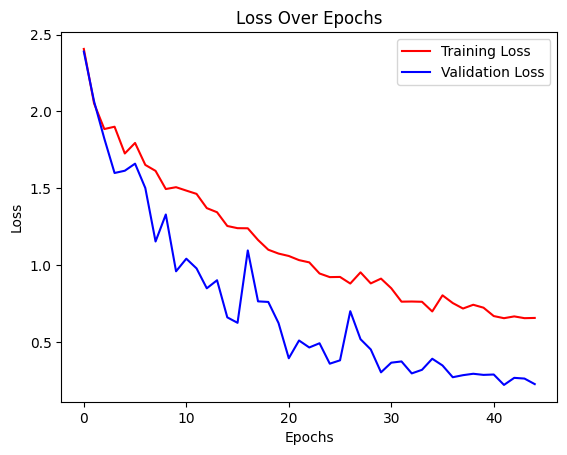

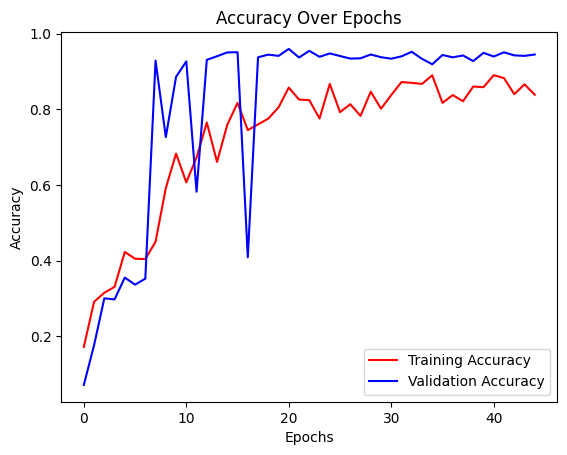

In [42]:
import torchvision.transforms.functional as F

seed_all(0)
g = torch.Generator()
g.manual_seed(0)

# Tensorboard
writer = SummaryWriter(os.path.join(root_path, 'logs', options['tensorboard']))

# Transformations
transform_train = transforms.Compose([transforms.ToTensor(),
                                RandomRotationTransform([-90, 0, 90, 180]),
                                transforms.RandomHorizontalFlip()])

transform_test = transforms.Compose([transforms.ToTensor()])

standardization = transforms.Normalize(bands_mean, bands_std)

# Construct Data loader
dataset_train = GenDEBRIS('train', transform=transform_train, standardization=standardization, agg_to_water=options['agg_to_water'])
dataset_test = GenDEBRIS('val', transform=transform_test, standardization=standardization, agg_to_water=options['agg_to_water'])

train_loader = DataLoader(dataset_train,
                          batch_size=options['batch'],
                          shuffle=True,
                          num_workers=options['num_workers'],
                          pin_memory=options['pin_memory'],
                          prefetch_factor=options['prefetch_factor'],
                          persistent_workers=options['persistent_workers'],
                          worker_init_fn=seed_worker,
                          generator=g)

test_loader = DataLoader(dataset_test,
                         batch_size=options['batch'],
                         shuffle=False,
                         num_workers=options['num_workers'],
                         pin_memory=options['pin_memory'],
                         prefetch_factor=options['prefetch_factor'],
                         persistent_workers=options['persistent_workers'],
                         worker_init_fn=seed_worker,
                         generator=g)

# Use gpu or cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# # SegNet
# model = SegNet(input_channels=options['input_channels'], output_channels=options['output_channels'])


# Residual U-Net
# model =  ResidualUNet(input_bands=options['input_channels'],
#              output_classes=options['output_channels'],
#              hidden_channels=options['hidden_channels'])


#Attention U-Net
# model = AttentionUNet(input_bands=options['input_channels'],
#              output_classes=options['output_channels'],
#              hidden_channels=options['hidden_channels'])

# U-Net
# model = UNet(input_bands=options['input_channels'],
#              output_classes=options['output_channels'],
#              hidden_channels=options['hidden_channels'])

# U-Net++

# model = NestedUNet(input_bands=options['input_channels'],
#              output_classes=options['output_channels'],
#              hidden_channels=options['hidden_channels'])

#Hybrid U-Net
# model = HybridUNet(input_bands=options['input_channels'],
#              output_classes=options['output_channels'],
#              hidden_channels=options['hidden_channels'])

# FCN
# model = FCN(input_channels=options['input_channels'], output_classes=options['output_channels'])


# Efficient U-Net
# model = EfficientUNet(input_bands=options['input_channels'],
#               output_classes=options['output_channels'],
#               hidden_channels=options['hidden_channels'])

# Transformer U-Net
model = TransformerUNet(input_bands=options['input_channels'],
               output_classes=options['output_channels'],
               hidden_channels=options['hidden_channels'])


model.to(device)

# Load model from specific epoch to continue the training or start the evaluation
if options['resume_from_epoch'] > 1:
    resume_model_dir = os.path.join(options['checkpoint_path'], str(options['resume_from_epoch']))
    model_file = os.path.join(resume_model_dir, 'model.pth')
    logging.info('Loading model files from folder: %s' % model_file)

    checkpoint = torch.load(model_file, map_location=device)
    model.load_state_dict(checkpoint)

    del checkpoint  # dereference
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

global class_distr
# Aggregate Distribution Mixed Water, Wakes, Cloud Shadows, Waves with Marine Water
if options['agg_to_water']:
    agg_distr = sum(class_distr[-4:])  # Density of Mixed Water, Wakes, Cloud Shadows, Waves
    class_distr[6] += agg_distr       # To Water
    class_distr = class_distr[:-4]    # Drop Mixed Water, Wakes, Cloud Shadows, Waves

# Weighted Cross Entropy Loss & adam optimizer
weight = gen_weights(class_distr, c=options['weight_param'])
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean', weight=weight.to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=options['lr'], weight_decay=options['decay'])

# Learning Rate scheduler
if options['reduce_lr_on_plateau'] == 1:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
else:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, options['lr_steps'], gamma=0.1, verbose=True)

# Start training
start = options['resume_from_epoch'] + 1
epochs = options['epochs']
eval_every = options['eval_every']

# Write model-graph to Tensorboard
t_loss = []
v_loss = []
v_acc = []
t_acc = []

dataiter = iter(train_loader)
image_temp, _ = next(dataiter)
# writer.add_graph(model, image_temp.to(device))

###############################################################
# Start Training                                              #
###############################################################
model.train()

for epoch in range(start, epochs + 1):
    training_loss = []
    training_batches = 0
    correct = 0
    total = 0
    i_board = 0
    for (image, target) in tqdm(train_loader, desc="training"):
        image = image.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        logits = model(image)
        
        loss = criterion(logits, target)

        loss.backward()

        training_batches += target.shape[0]

        training_loss.append((loss.data * target.shape[0]).tolist())

        optimizer.step()

        # Compute Training Accuracy
        with torch.no_grad():
            preds = torch.argmax(logits, dim=1)
            mask = target != -1  # Ignore invalid pixels
            correct += (preds[mask] == target[mask]).sum().item()
            total += mask.sum().item()
            
        
        # Write running loss
        writer.add_scalar('training loss', loss, (epoch - 1) * len(train_loader) + i_board)
        i_board += 1
        
    # Store training accuracy
    train_acc = correct / total
    t_acc.append(train_acc)  # Append to training accuracy list

    t_loss.append(sum(training_loss) / training_batches)
    logging.info("Training loss was: " + str(sum(training_loss) / training_batches))
    print(f"Epoch {epoch}: Training loss was: {sum(training_loss) / training_batches}")

    ###############################################################
    # Start Evaluation                                            #
    ###############################################################

    if epoch % eval_every == 0 or epoch == 1:
        model.eval()

        test_loss = []
        test_batches = 0
        y_true = []
        y_predicted = []

        with torch.no_grad():
            for (image, target) in tqdm(test_loader, desc="testing"):
                image = image.to(device)
                target = target.to(device)

                logits = model(image)

                loss = criterion(logits, target)

                # Accuracy metrics only on annotated pixels
                logits = torch.movedim(logits, (0, 1, 2, 3), (0, 3, 1, 2))
                logits = logits.reshape((-1, options['output_channels']))
                target = target.reshape(-1)
                mask = target != -1
                logits = logits[mask]
                target = target[mask]

                probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
                target = target.cpu().numpy()

                test_batches += target.shape[0]
                test_loss.append((loss.data * target.shape[0]).tolist())
                y_predicted += probs.argmax(1).tolist()
                y_true += target.tolist()

            y_predicted = np.asarray(y_predicted)
            y_true = np.asarray(y_true)

            ####################################################################
            # Save Scores to the .log file and visualize also with tensorboard #
            ####################################################################
            acc = Evaluation(y_predicted, y_true)
            logging.info("\n")
            logging.info("Test loss was: " + str(sum(test_loss) / test_batches))
            logging.info("STATISTICS AFTER EPOCH " + str(epoch) + ": \n")
            logging.info("Evaluation: " + str(acc))
            print(f"Epoch {epoch}: Test loss was: {sum(test_loss) / test_batches}")
            print(f"STATISTICS AFTER EPOCH {epoch}: \n")
            print(f"Evaluation: {acc}")
            v_loss.append(sum(test_loss) / test_batches)
            v_acc.append(acc['subsetAcc'])

            logging.info("Saving models")
            model_dir = os.path.join(options['checkpoint_path'], str(epoch))
            model_dir = options['checkpoint_path'] + str(epoch)
            os.makedirs(model_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(model_dir, 'model.pth'))

            writer.add_scalars('Loss per epoch', {'Test loss': sum(test_loss) / test_batches,
                                                  'Train loss': sum(training_loss) / training_batches},
                               epoch)

            writer.add_scalar('Precision/test macroPrec', acc["macroPrec"], epoch)
            writer.add_scalar('Precision/test microPrec', acc["microPrec"], epoch)
            writer.add_scalar('Precision/test weightPrec', acc["weightPrec"], epoch)

            writer.add_scalar('Recall/test macroRec', acc["macroRec"], epoch)
            writer.add_scalar('Recall/test microRec', acc["microRec"], epoch)
            writer.add_scalar('Recall/test weightRec', acc["weightRec"], epoch)

            writer.add_scalar('F1/test macroF1', acc["macroF1"], epoch)
            writer.add_scalar('F1/test microF1', acc["microF1"], epoch)
            writer.add_scalar('F1/test weightF1', acc["weightF1"], epoch)

            writer.add_scalar('IoU/test MacroIoU', acc["IoU"], epoch)

        if options['reduce_lr_on_plateau'] == 1:
            scheduler.step(sum(test_loss) / test_batches)
        else:
            scheduler.step()

        model.train()

# plt.figure()
# plt.plot(t_loss, 'r')
# plt.plot(v_loss, 'b')
# plt.legend(['train', 'validation'])
# plt.figure()
# plt.plot(v_acc, 'r')
# Plotting the losses over epochs
plt.figure()
plt.plot(t_loss, 'r', label='Training Loss')
plt.plot(v_loss, 'b', label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')  # Optional: Save the plot
plt.show()

# Plotting the validation accuracy over epochs
plt.figure()
plt.plot(t_acc, 'r', label='Training Accuracy')
plt.plot(v_acc, 'b', label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')  # Optional: Save the plot
plt.show()

# Testing

testing:   0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
testing:   5%|▌         | 19/359 [00:01<00:21, 16.02it/s]/tmp/ipykernel_30/3962939884.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
testing: 100%|██████████| 359/359 [00:28<00:00, 12.58it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

Test loss was: 0.3080125290919376
STATISTICS: 

Evaluation: {'macroPrec': 0.6963556348582642, 'microPrec': 0.9229048100460323, 'weightPrec': 0.9347754886491387, 'macroRec': 0.6297426248300209, 'microRec': 0.9229048100460323, 'weightRec': 0.9229048100460323, 'macroF1': 0.586836194637267, 'microF1': 0.9229048100460323, 'weightF1': 0.9230350369434975, 'subsetAcc': 0.9229048100460323, 'IoU': 0.48826743836375947}
[ 0  1  2  3  4  5  6  7  8  9 10]

📊 Per-Class Accuracy:
Marine Debris: 0.6562
Dense Sargassum: 0.0500
Sparse Sargassum: 0.8808
Natural Organic Material: 0.0000
Ship: 0.8049
Clouds: 0.7633
Water: 0.9183
Sediment-Laden Water: 0.9925
Foam: 0.1525
Turbid Water: 0.9409
Shallow Water: 0.7678

✅ Most Accurate Class: Sediment-Laden Water (0.9925)
⚠️ Least Accurate Class: Natural Organic Material (0.0000)


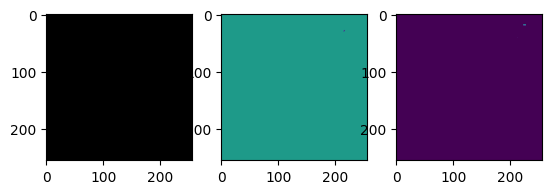

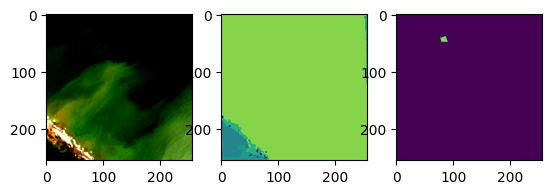

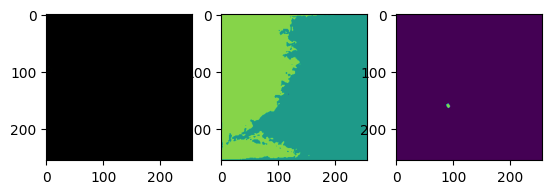

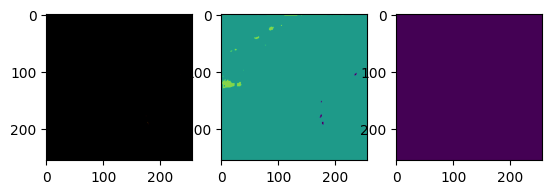

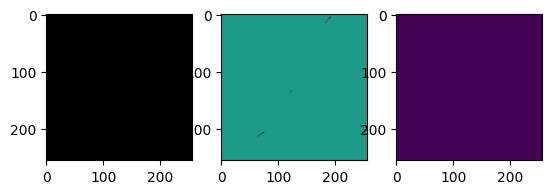

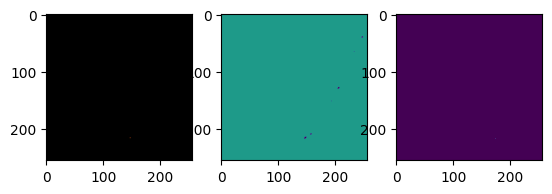

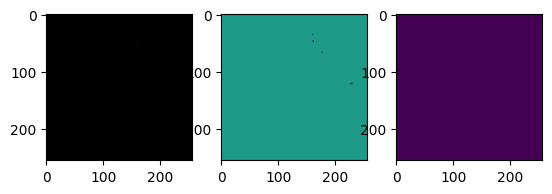

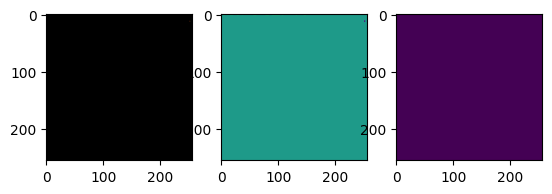

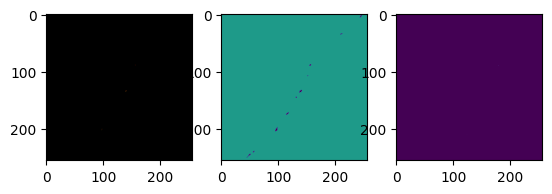

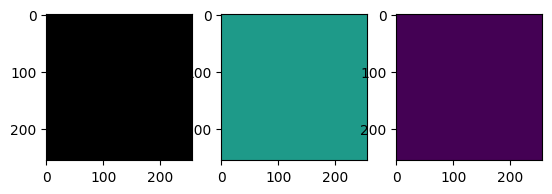

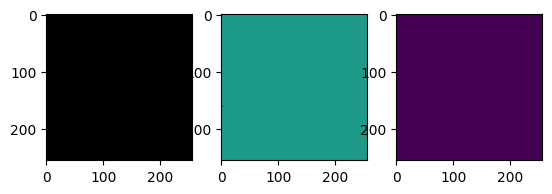

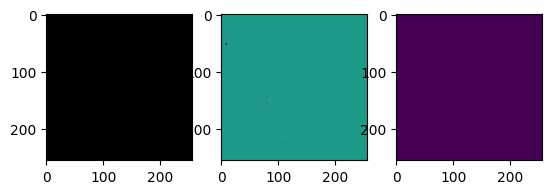

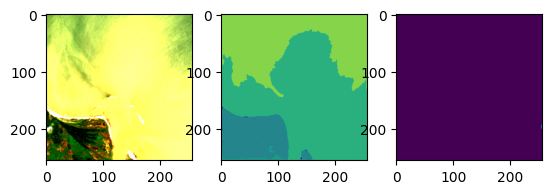

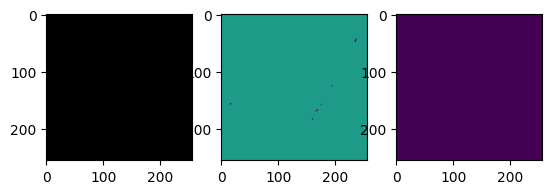

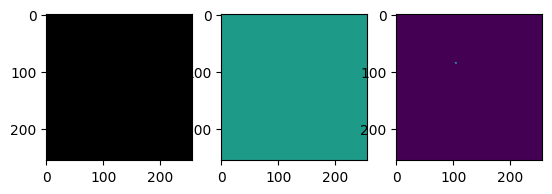

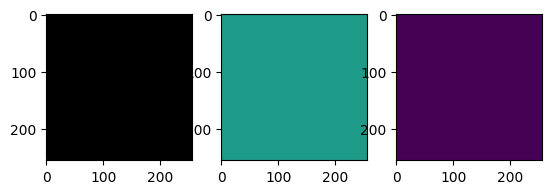

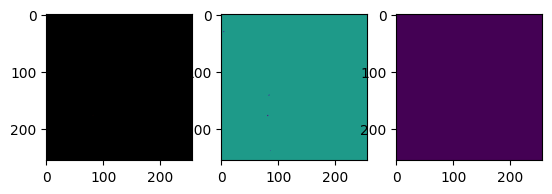

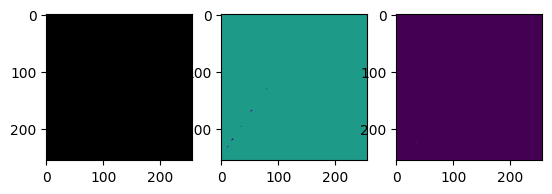

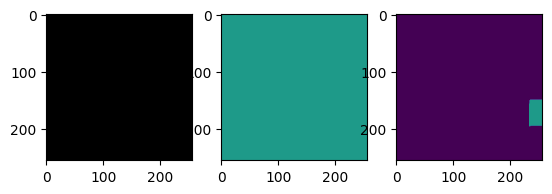

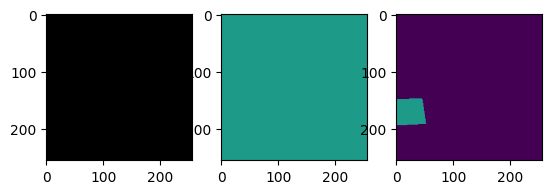

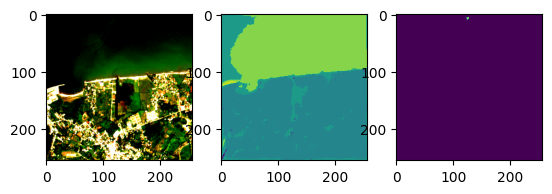

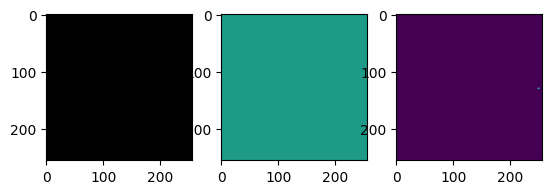

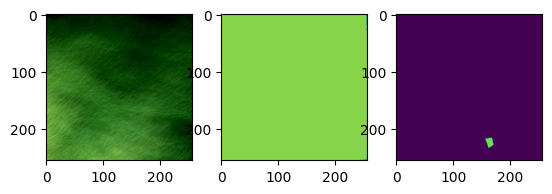

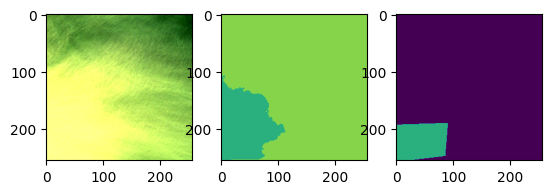

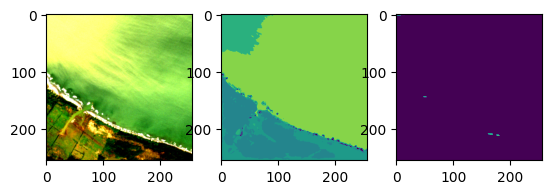

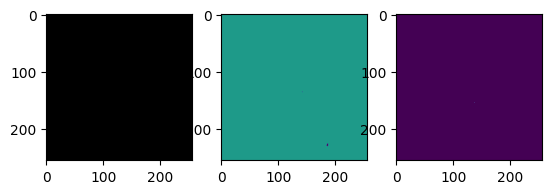

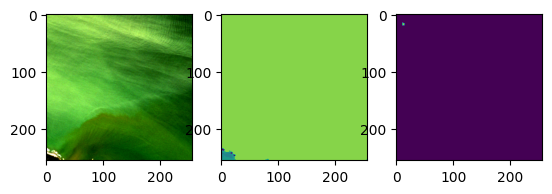

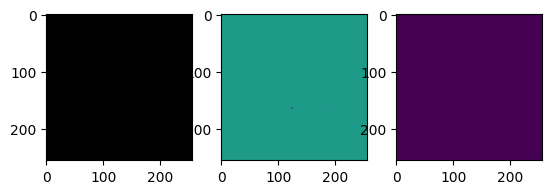

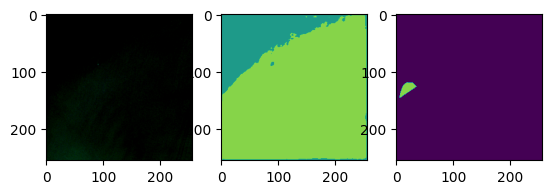

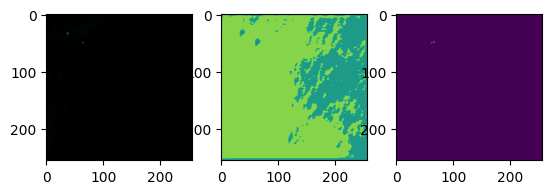

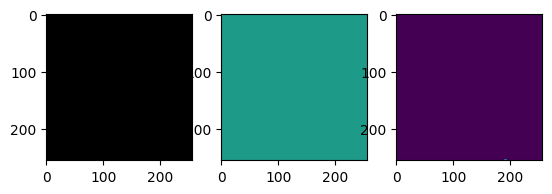

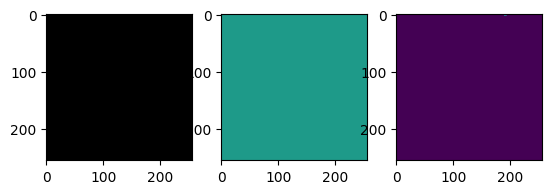

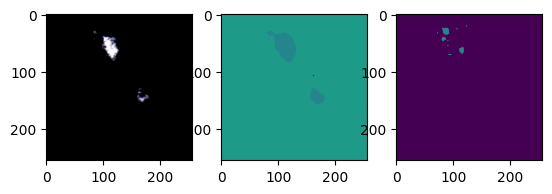

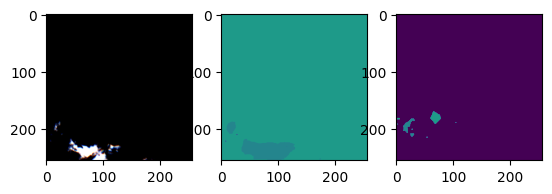

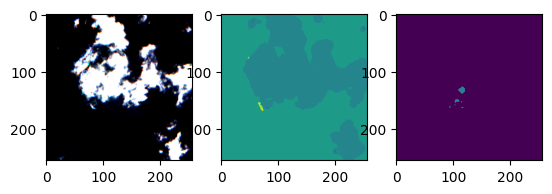

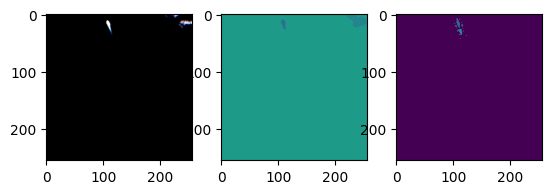

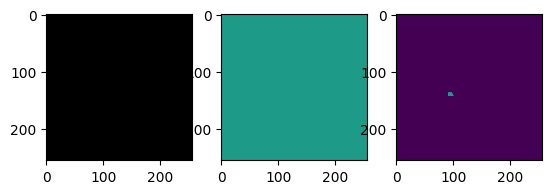

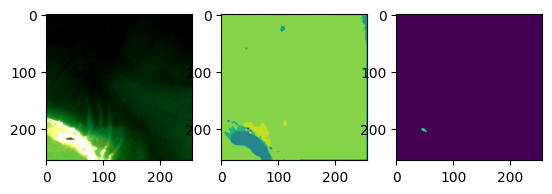

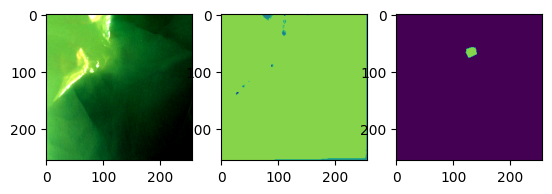

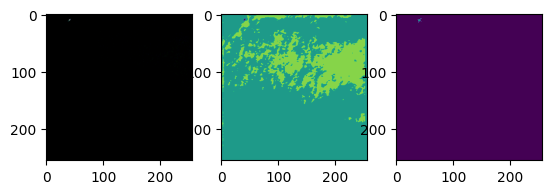

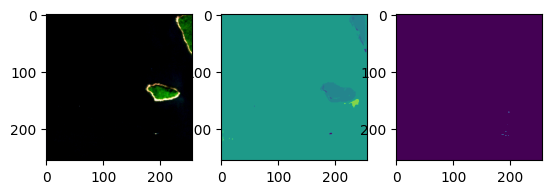

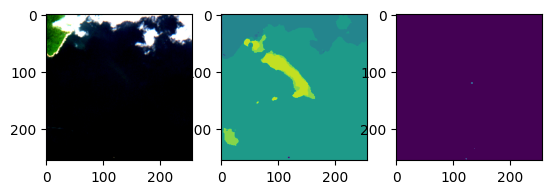

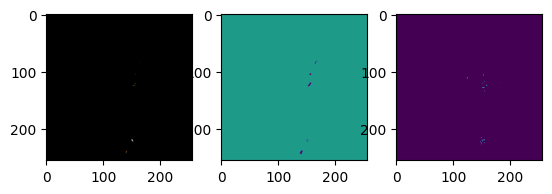

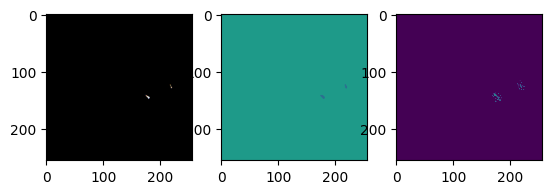

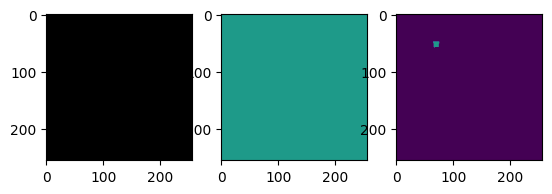

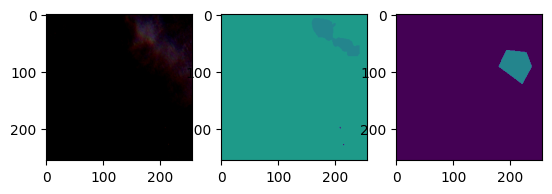

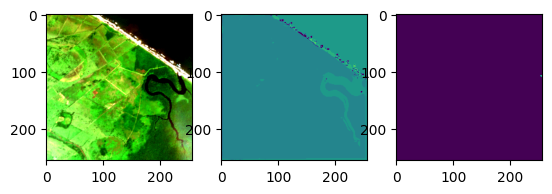

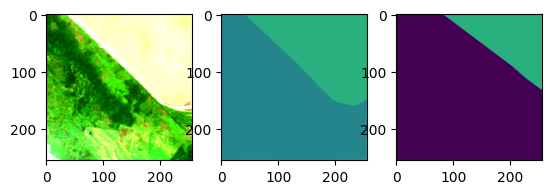

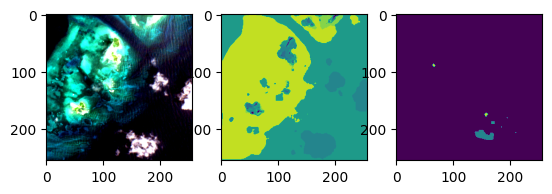

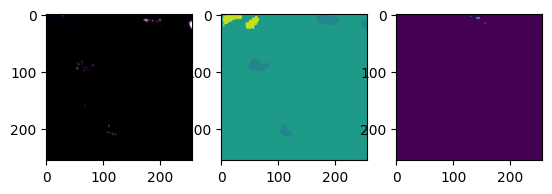

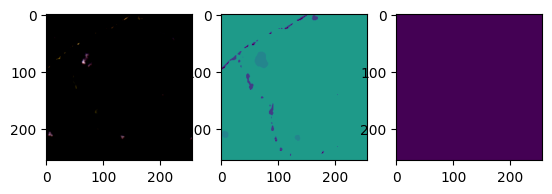

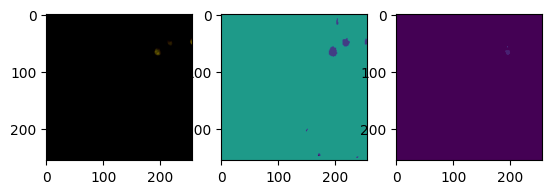

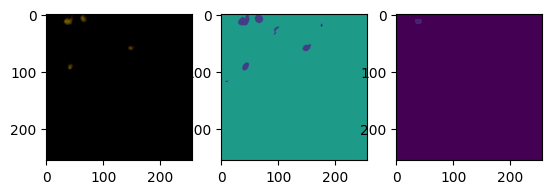

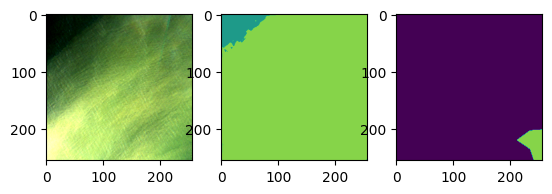

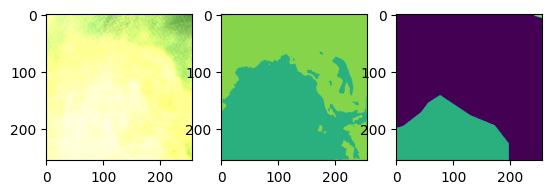

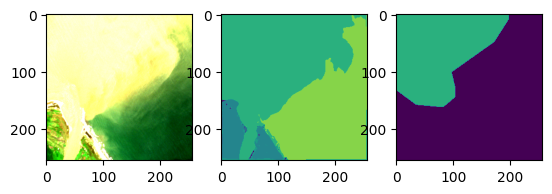

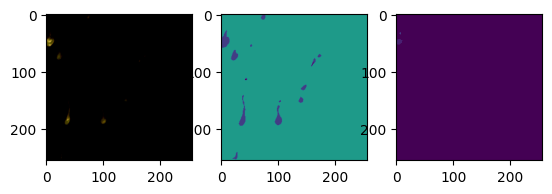

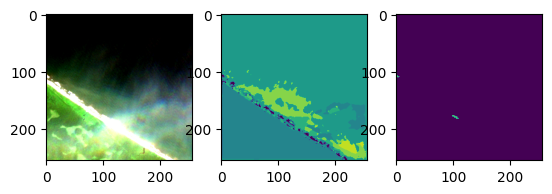

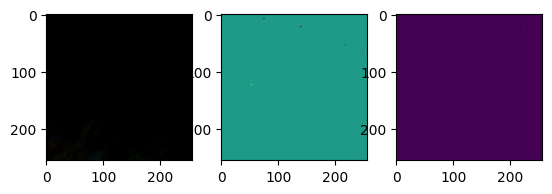

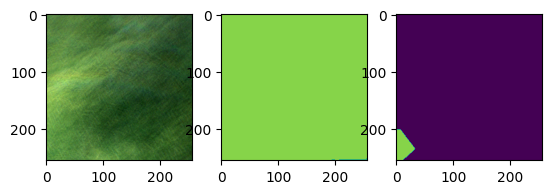

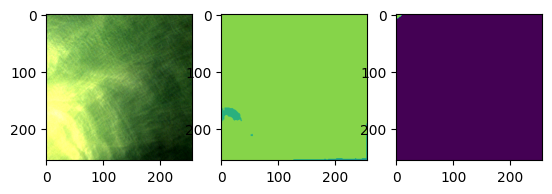

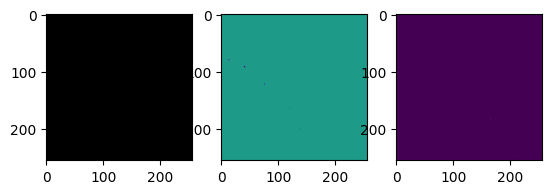

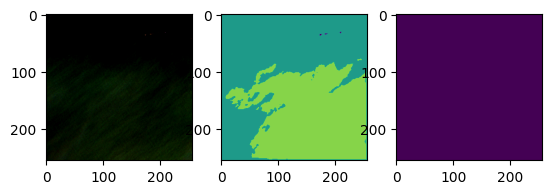

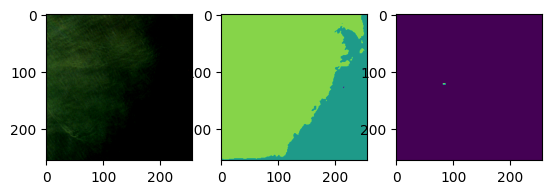

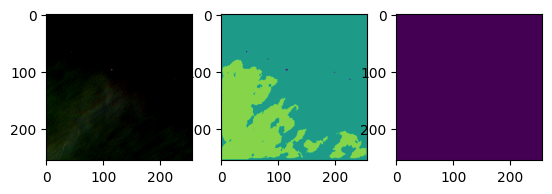

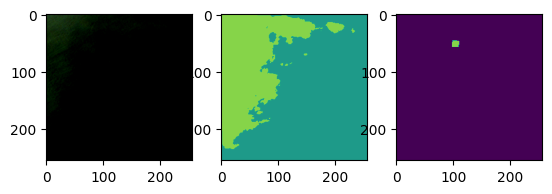

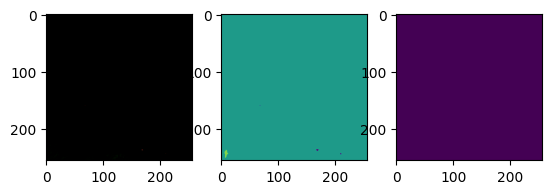

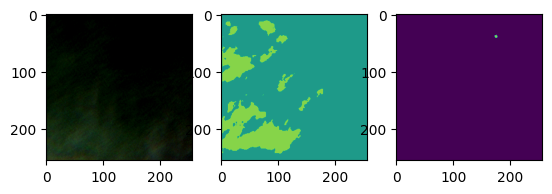

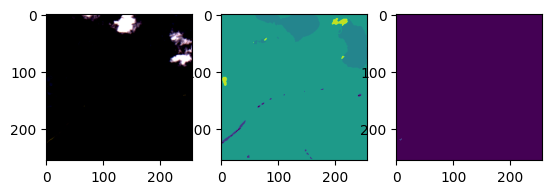

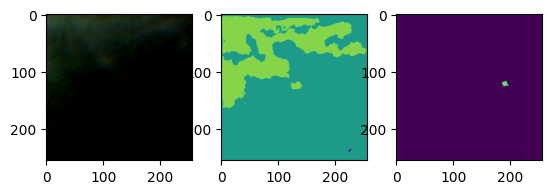

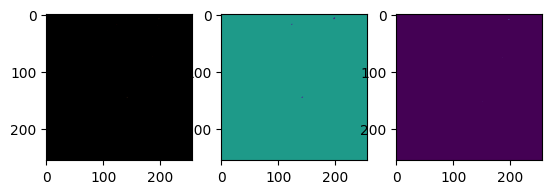

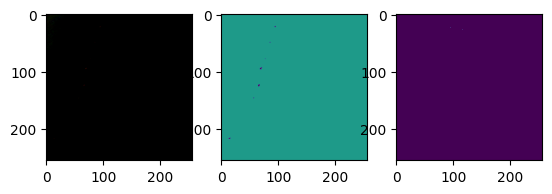

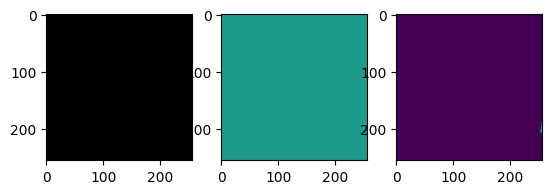

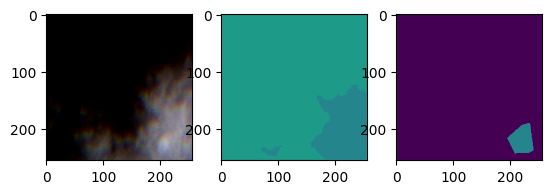

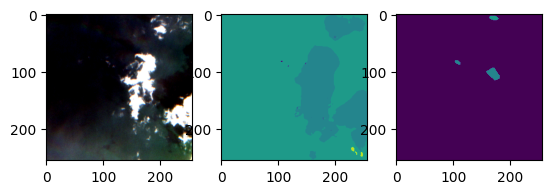

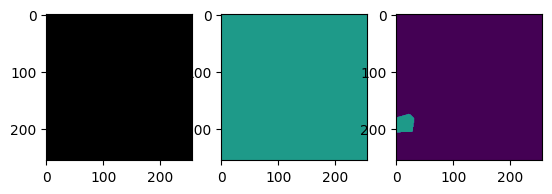

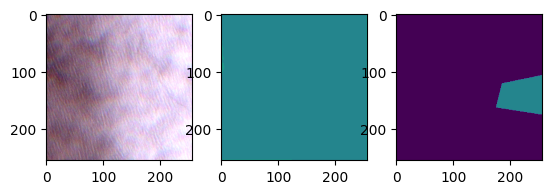

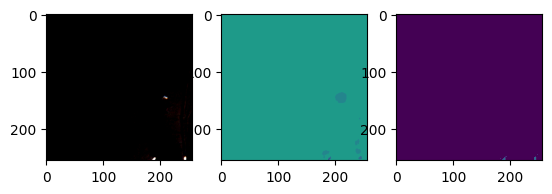

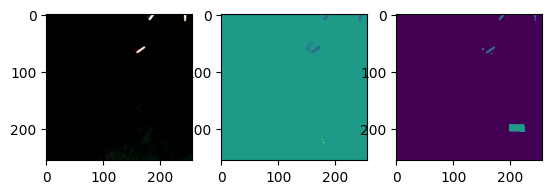

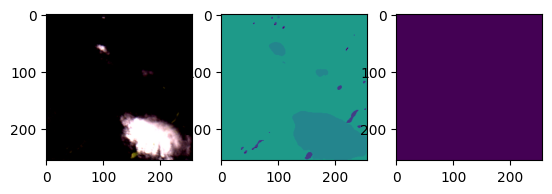

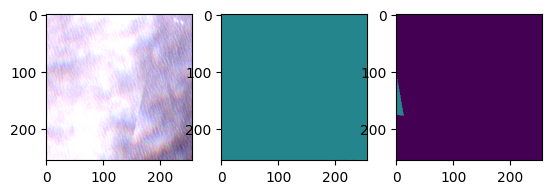

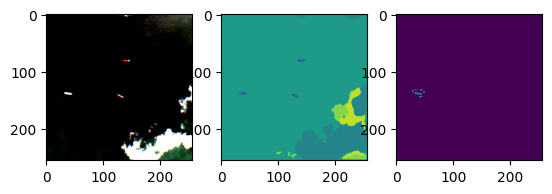

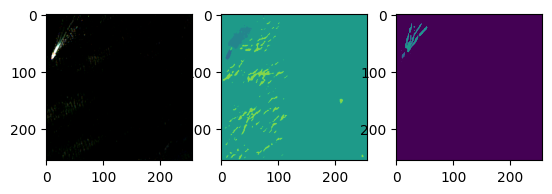

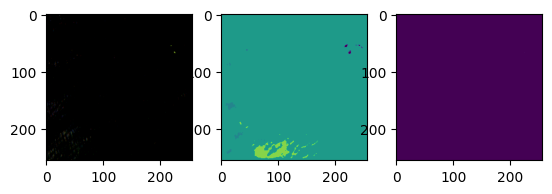

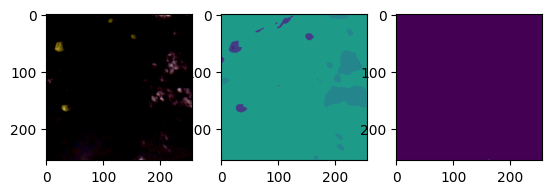

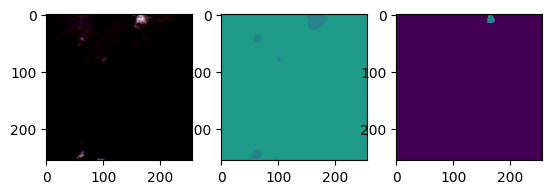

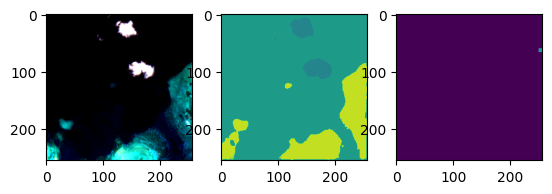

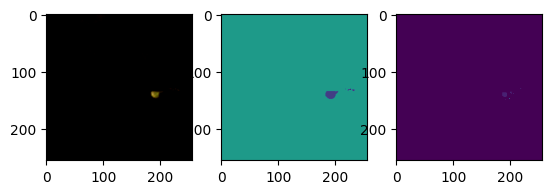

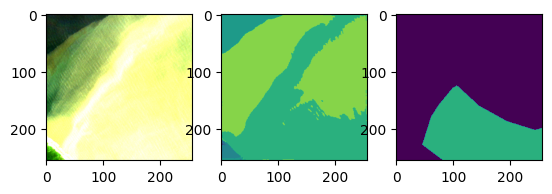

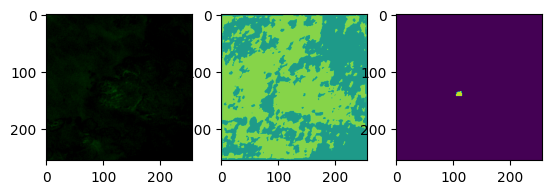

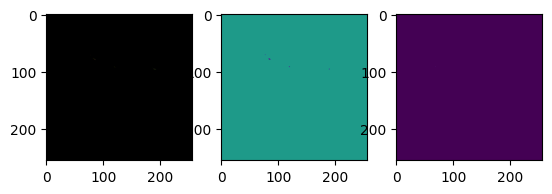

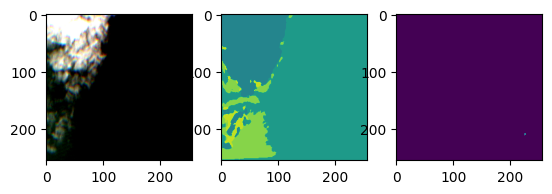

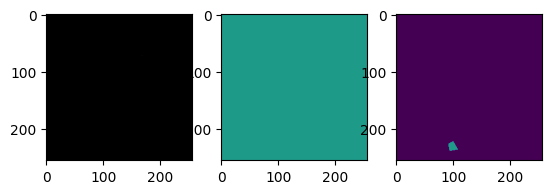

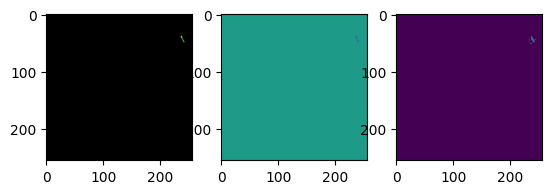

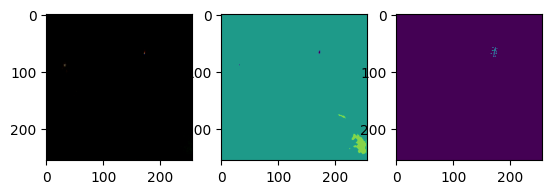

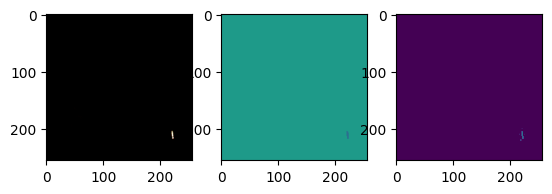

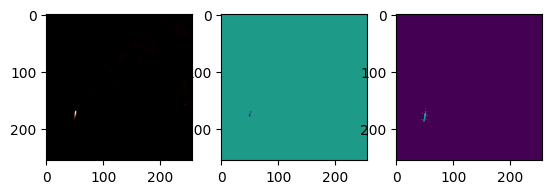

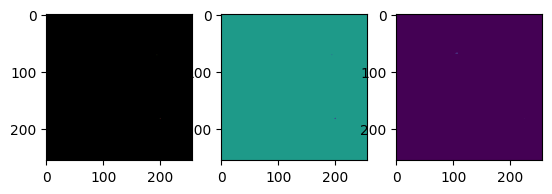

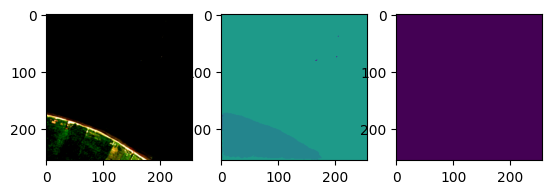

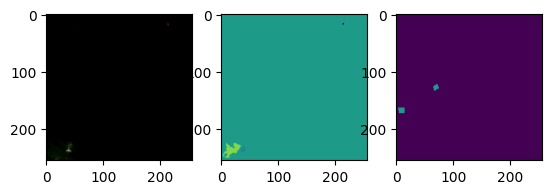

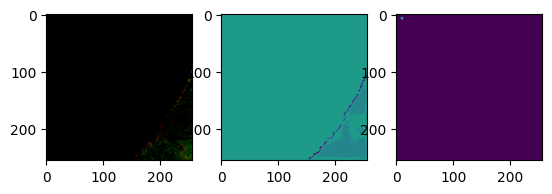

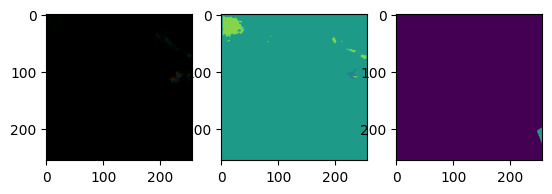

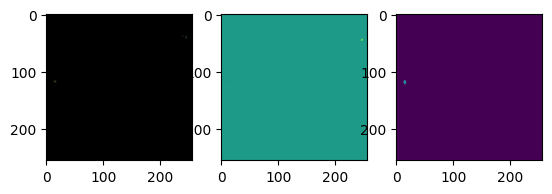

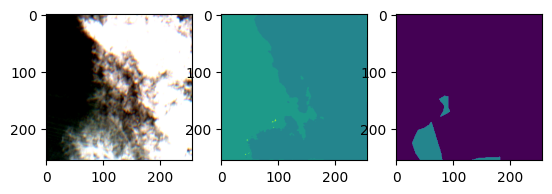

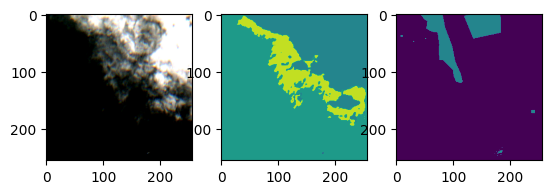

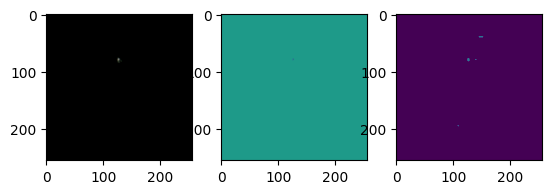

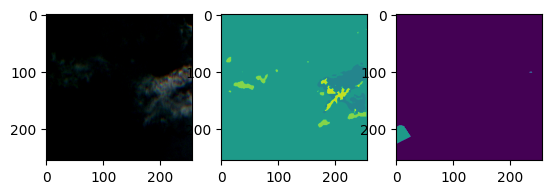

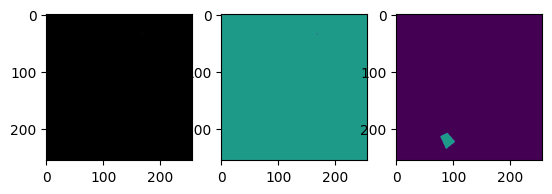

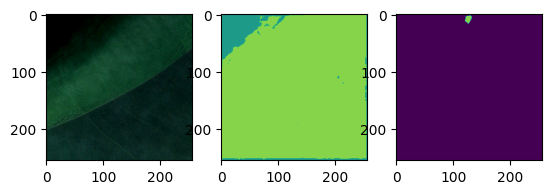

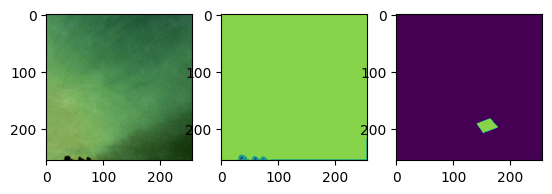

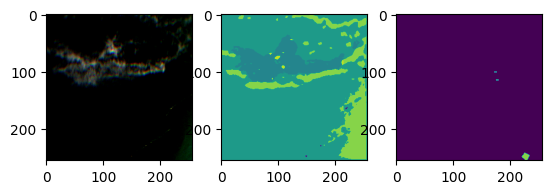

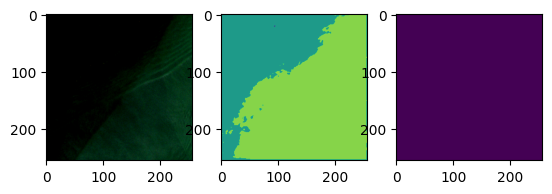

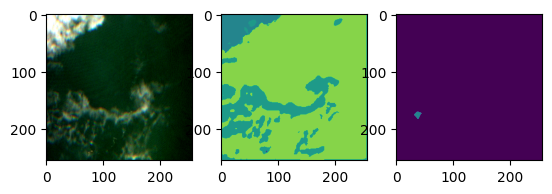

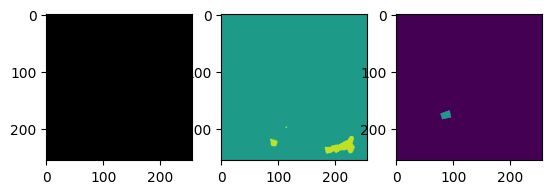

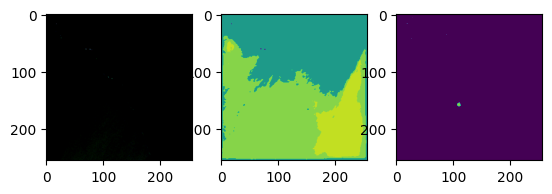

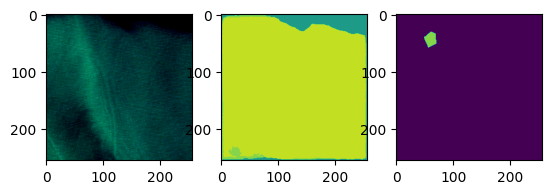

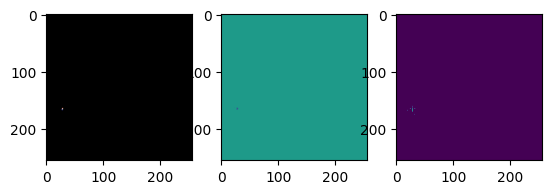

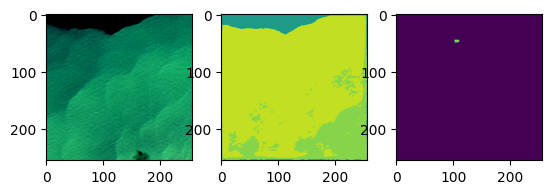

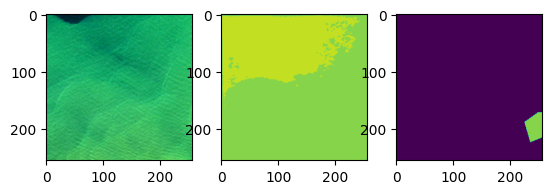

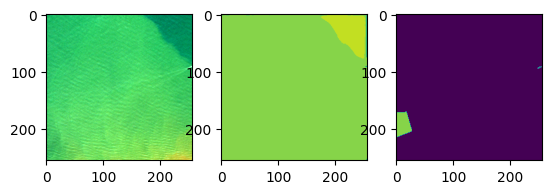

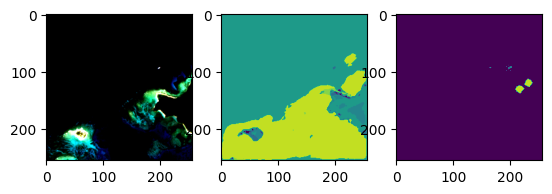

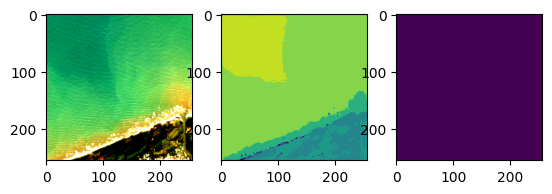

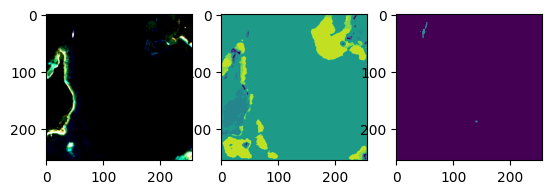

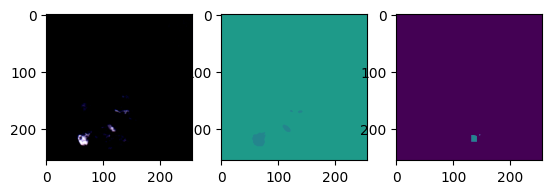

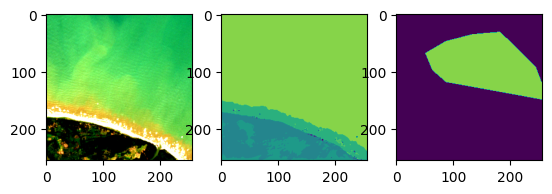

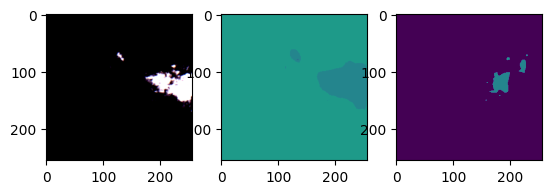

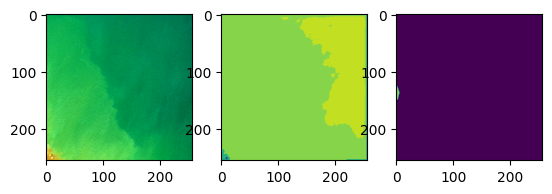

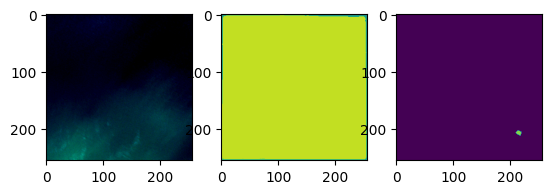

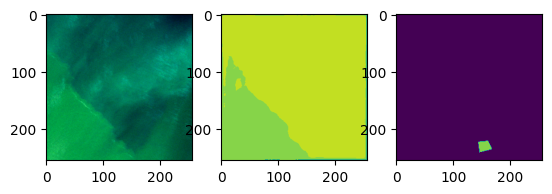

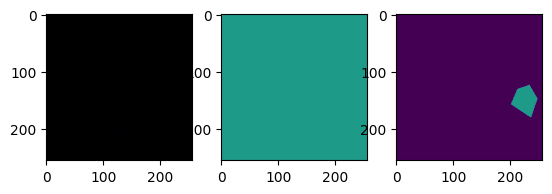

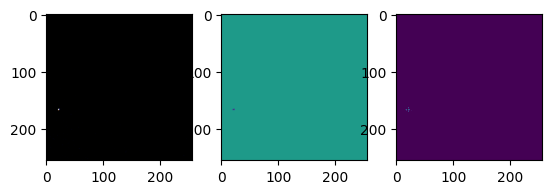

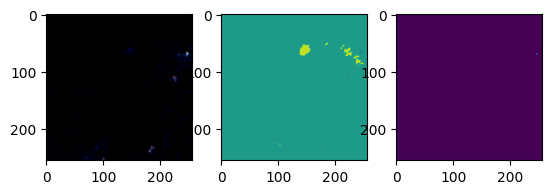

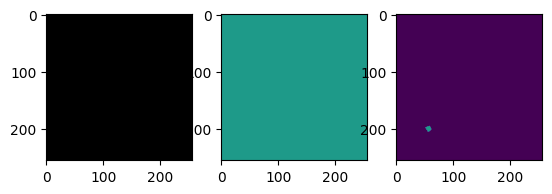

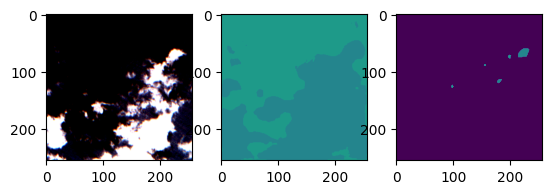

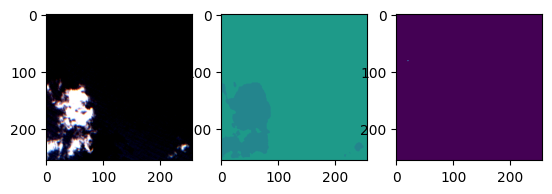

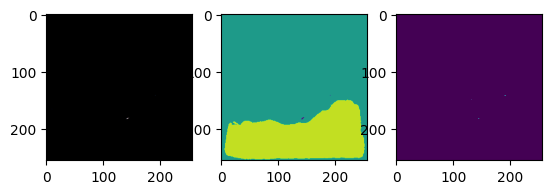

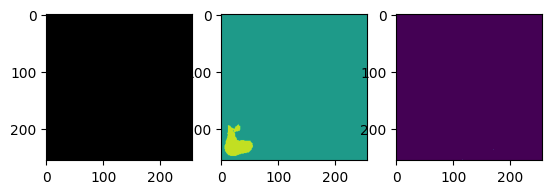

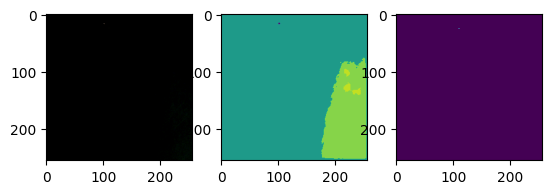

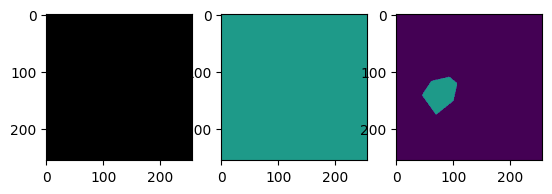

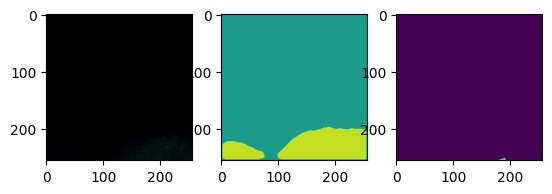

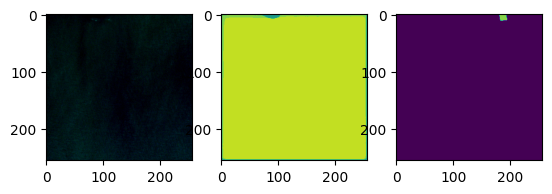

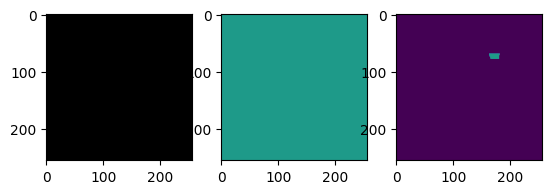

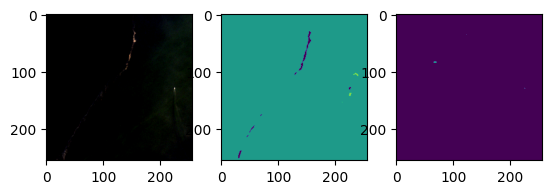

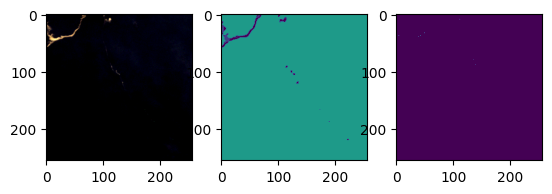

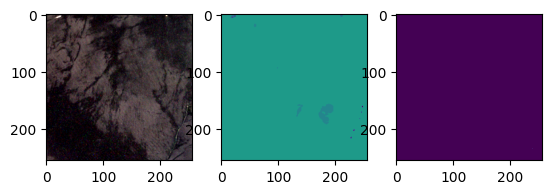

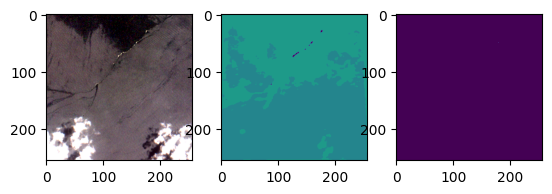

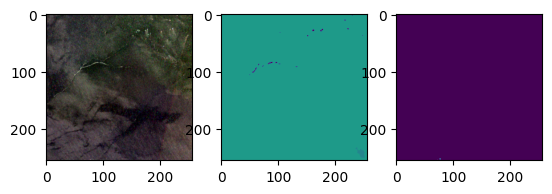

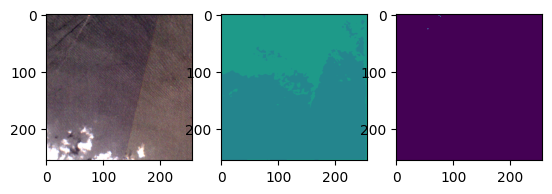

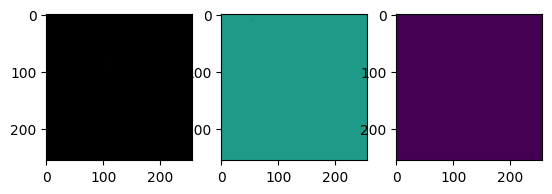

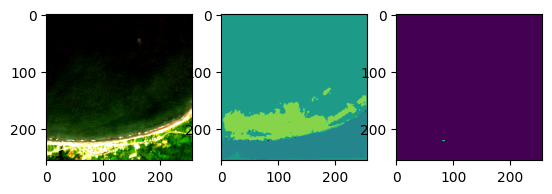

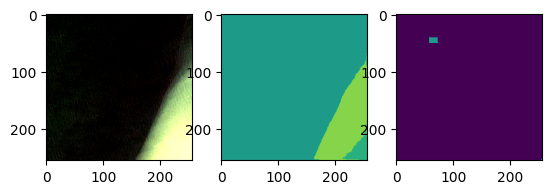

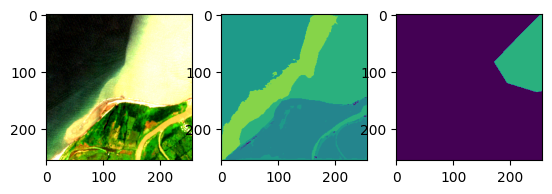

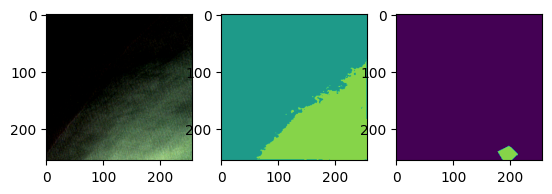

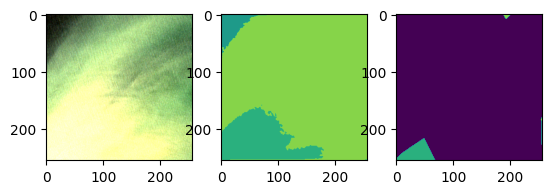

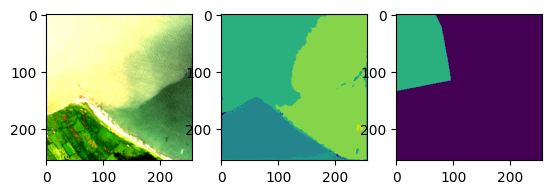

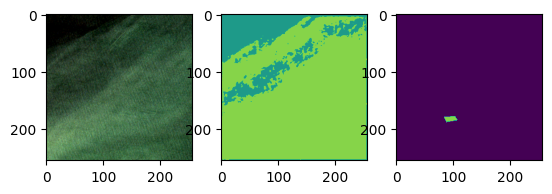

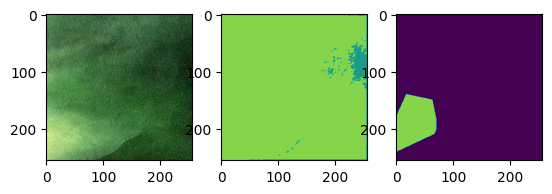

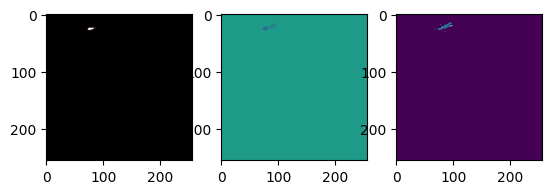

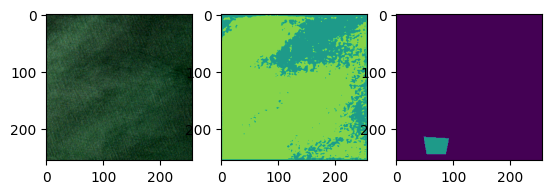

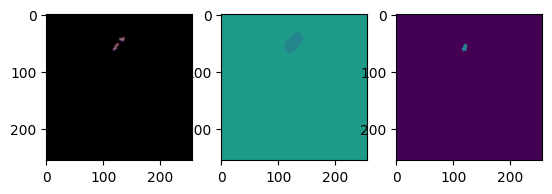

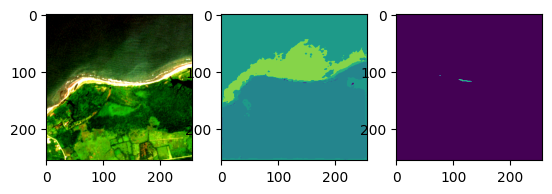

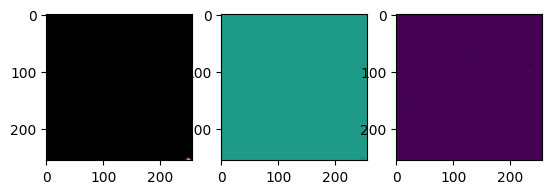

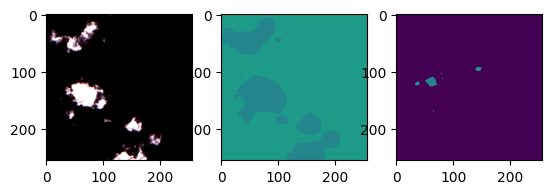

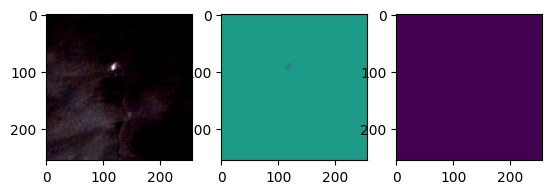

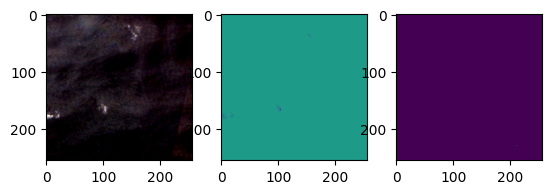

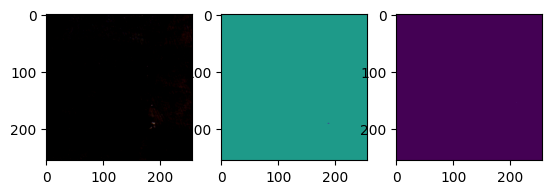

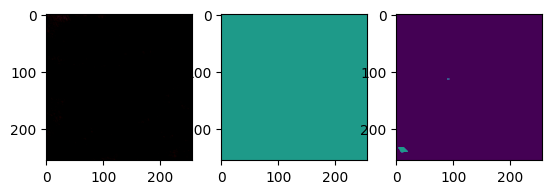

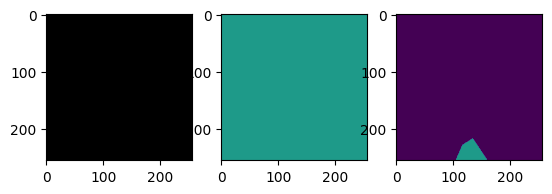

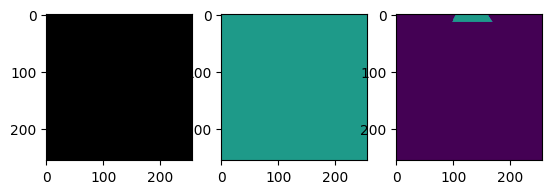

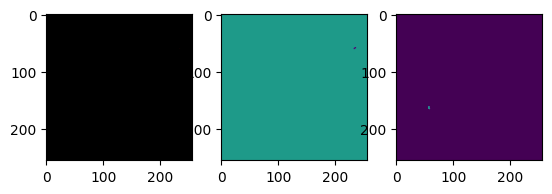

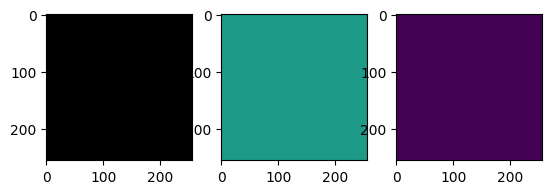

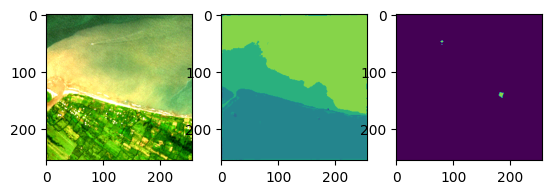

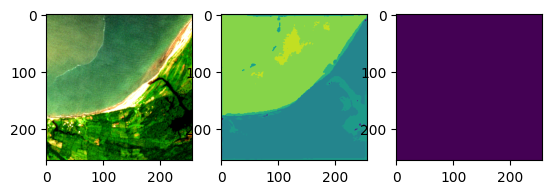

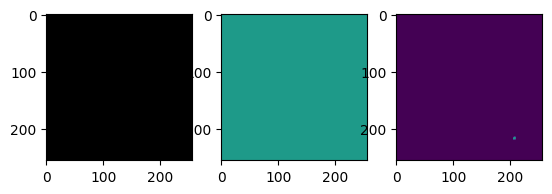

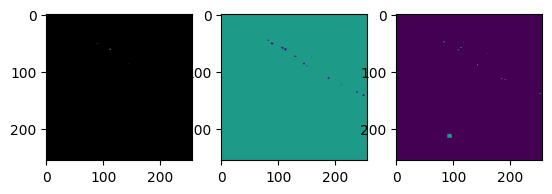

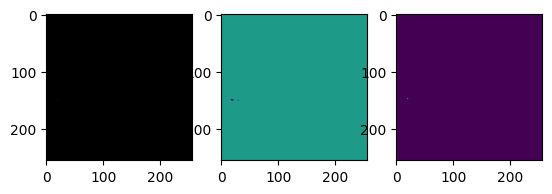

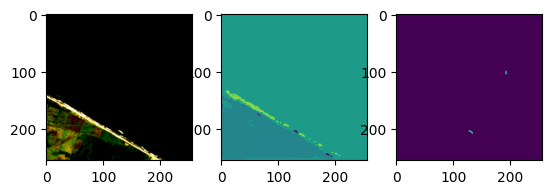

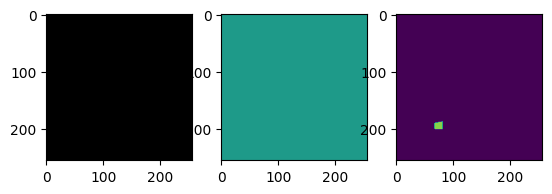

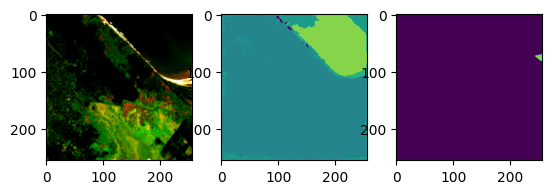

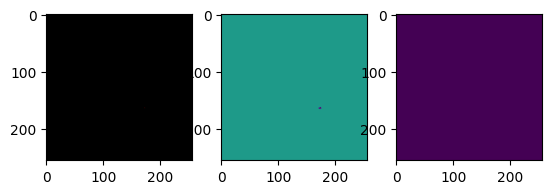

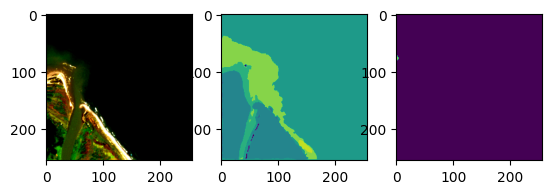

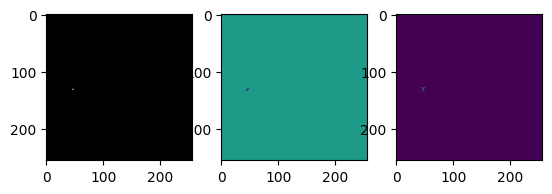

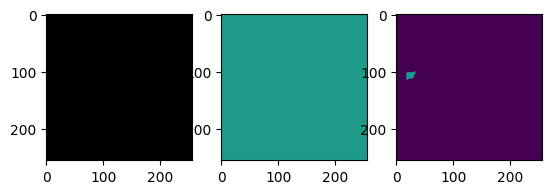

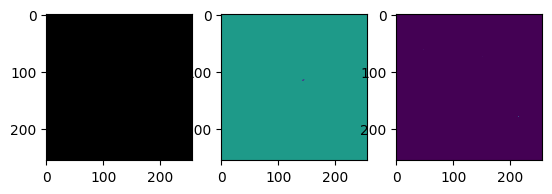

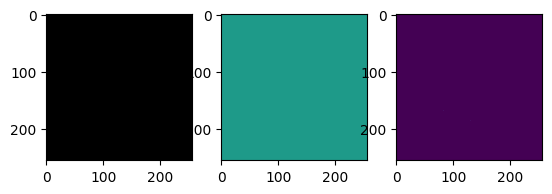

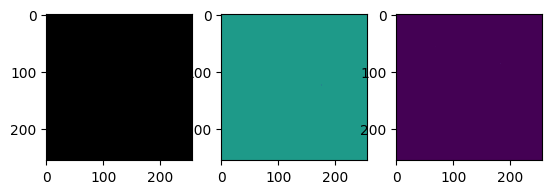

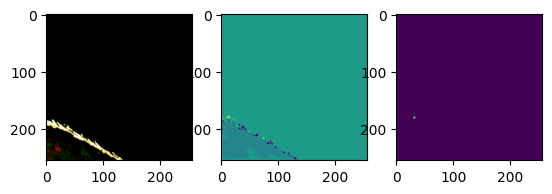

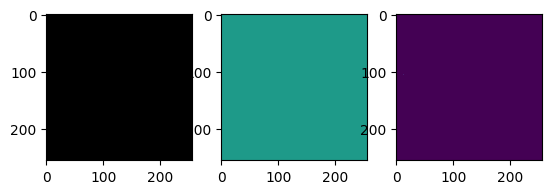

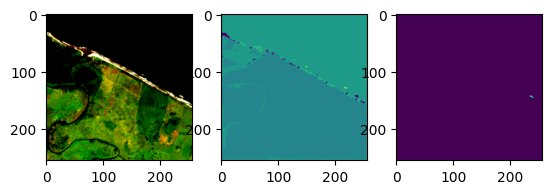

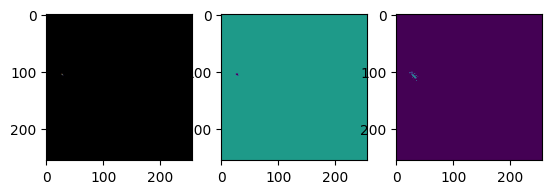

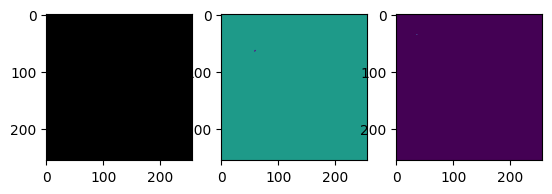

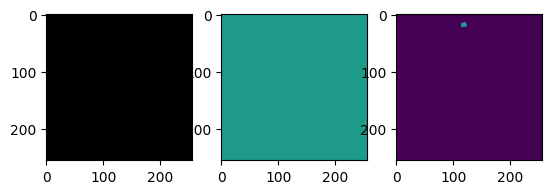

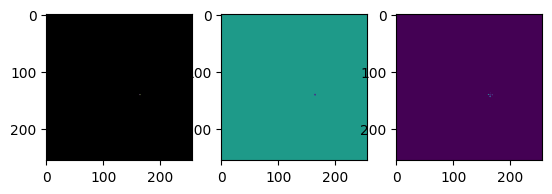

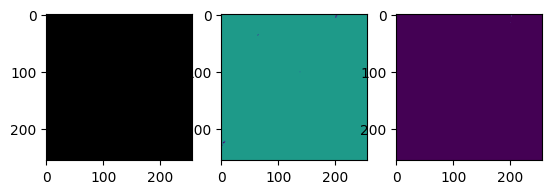

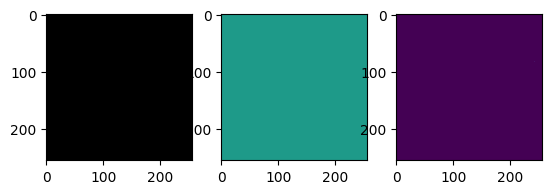

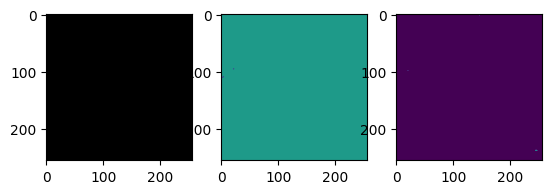

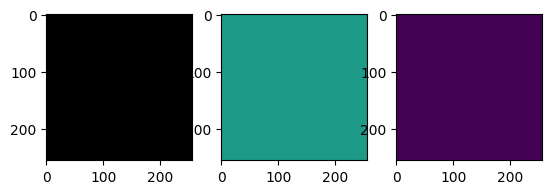

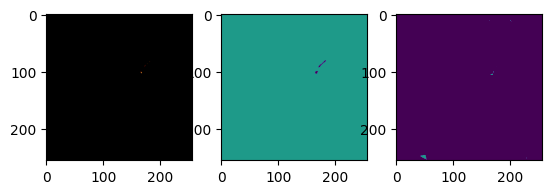

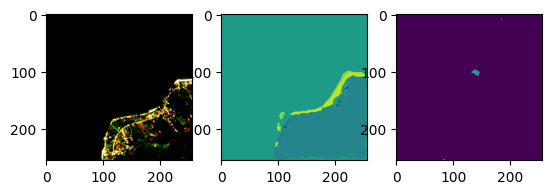

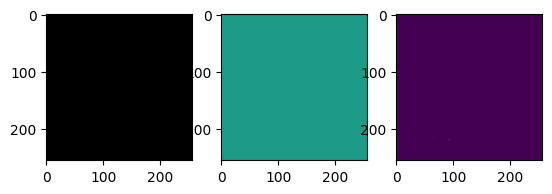

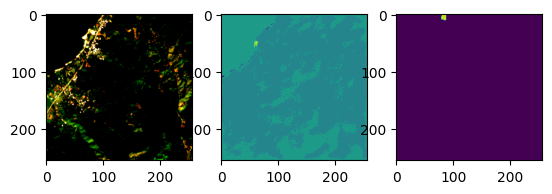

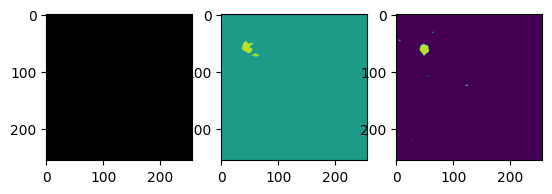

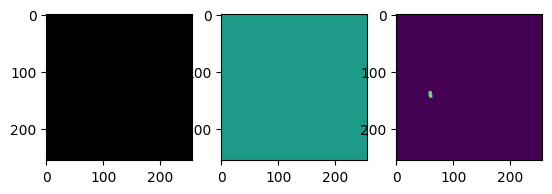

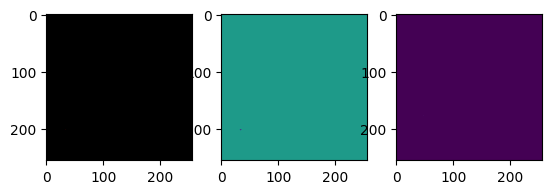

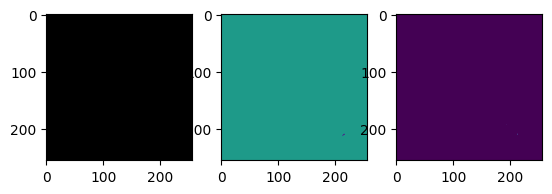

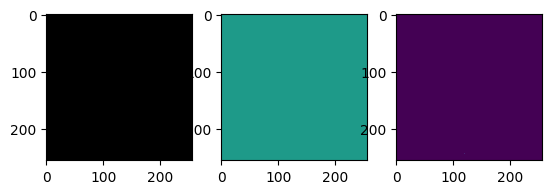

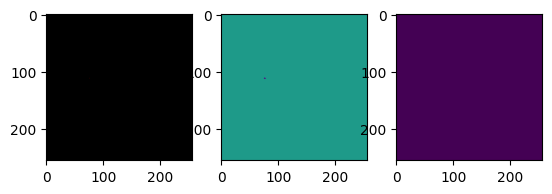

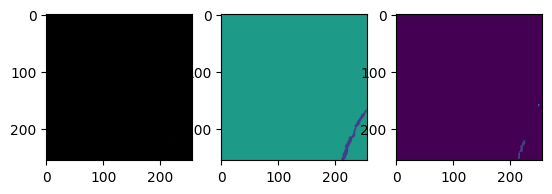

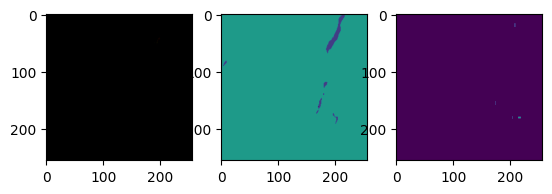

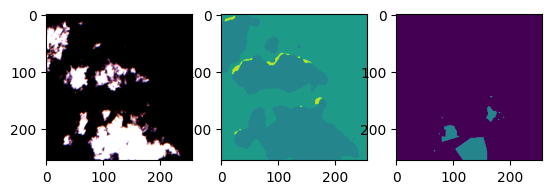

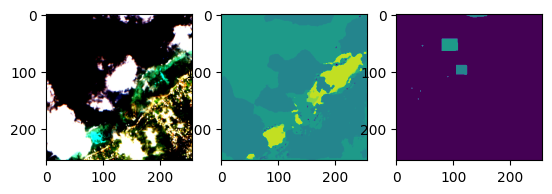

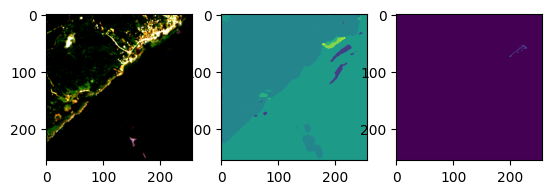

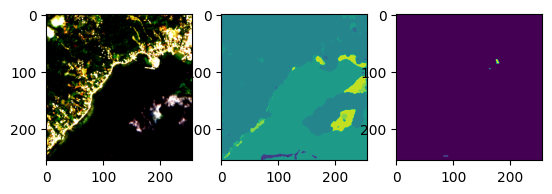

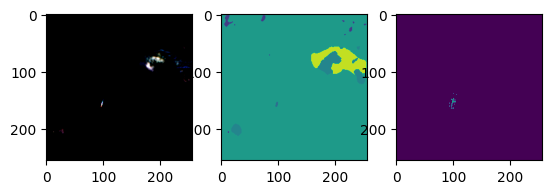

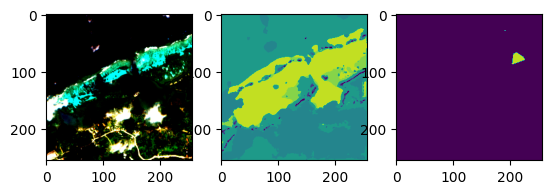

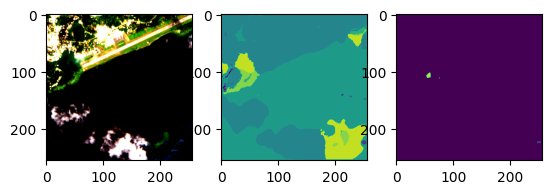

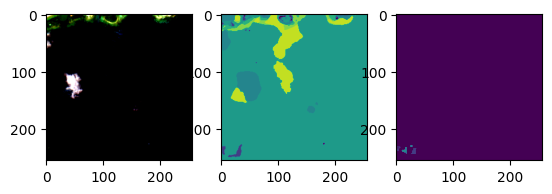

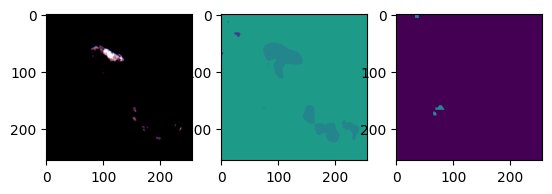

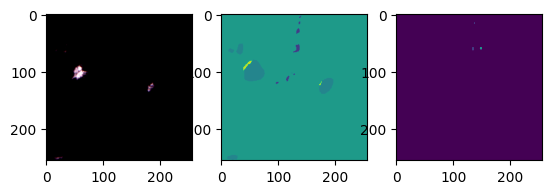

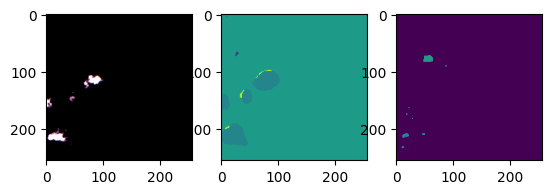

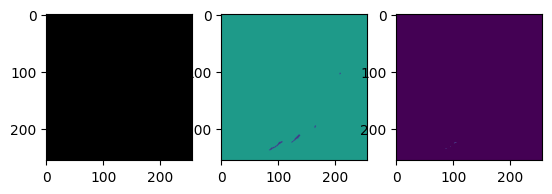

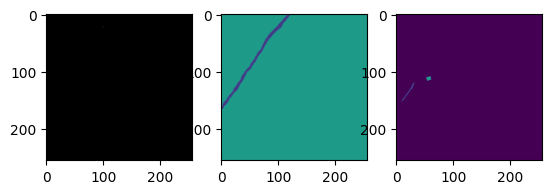

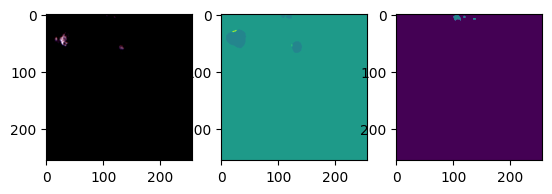

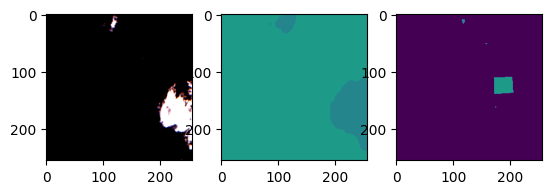

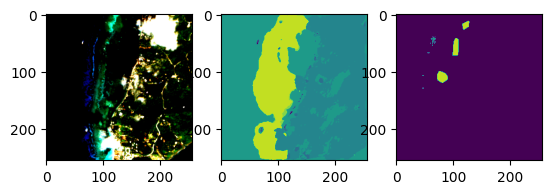

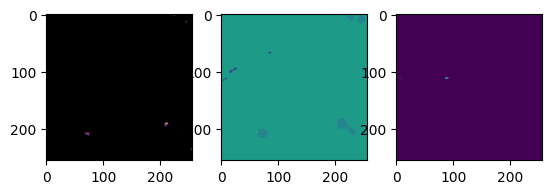

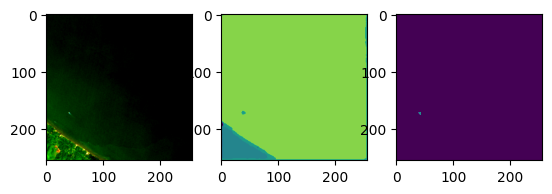

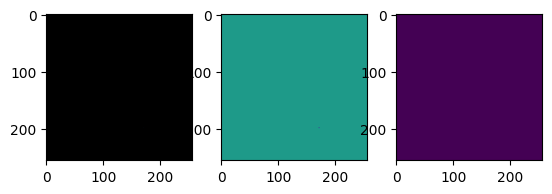

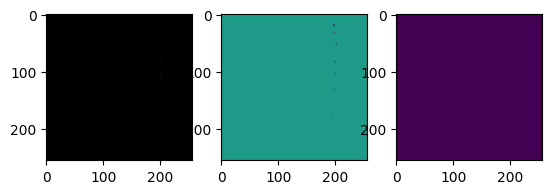

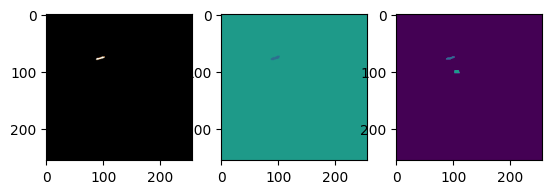

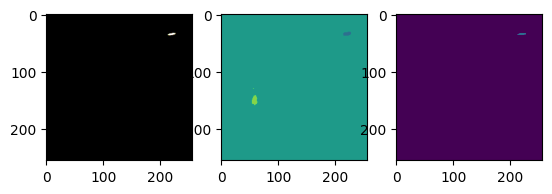

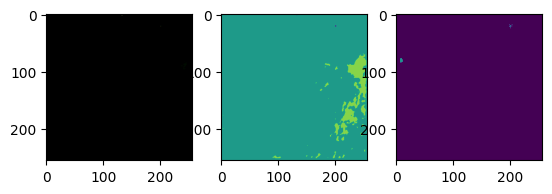

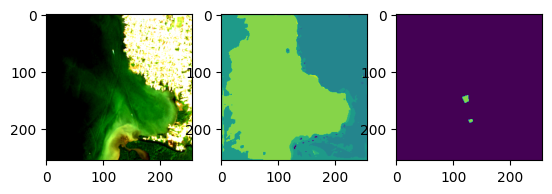

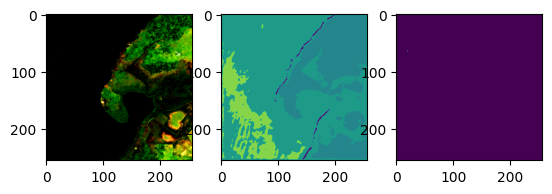

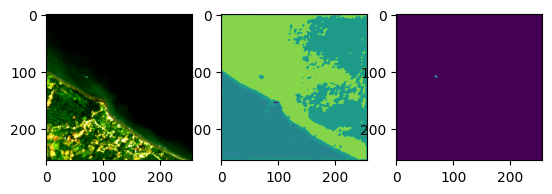

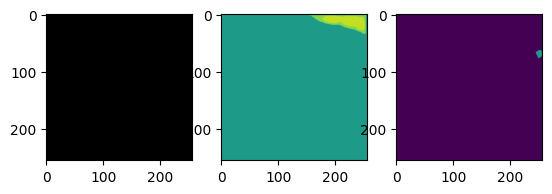

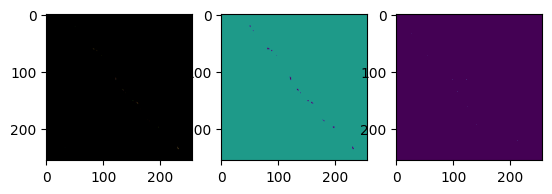

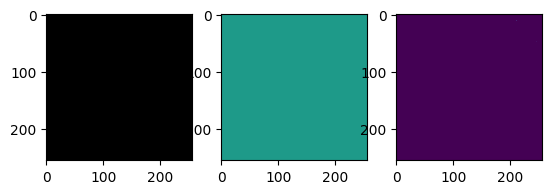

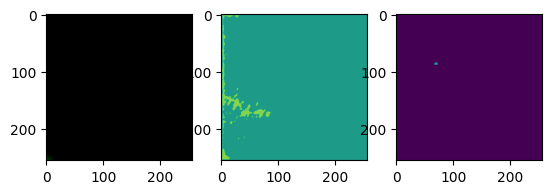

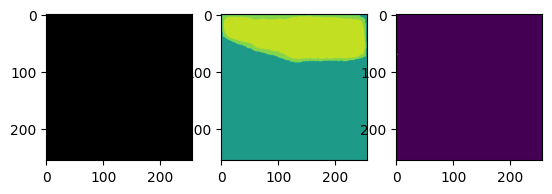

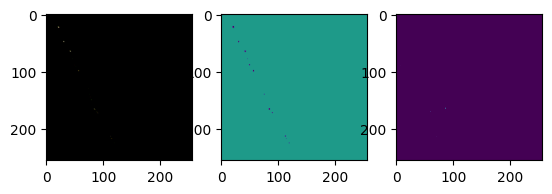

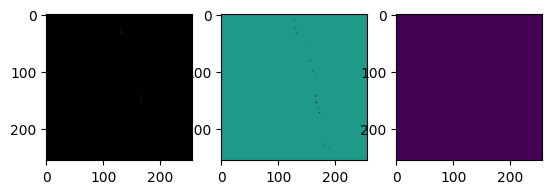

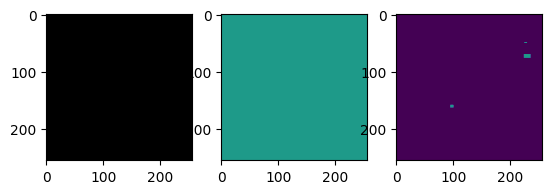

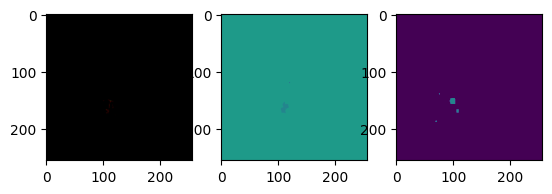

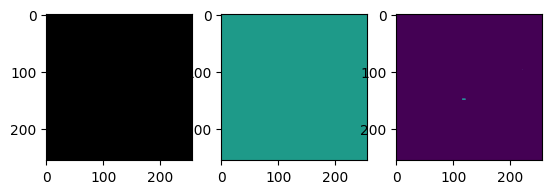

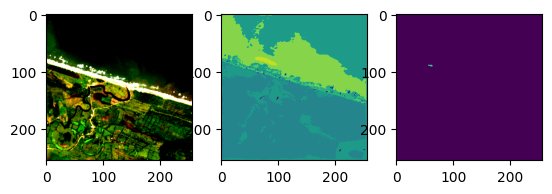

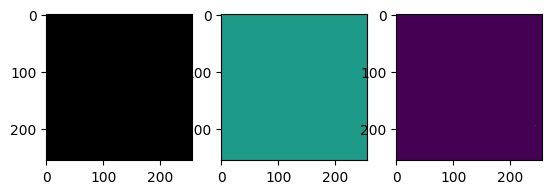

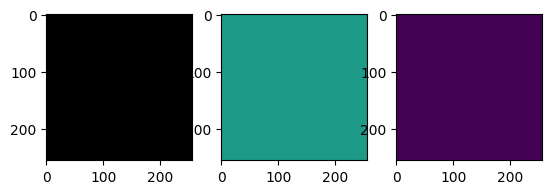

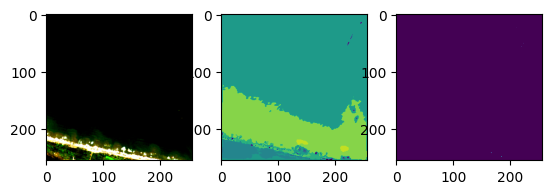

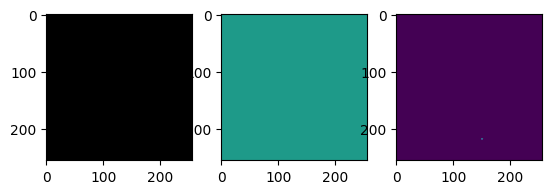

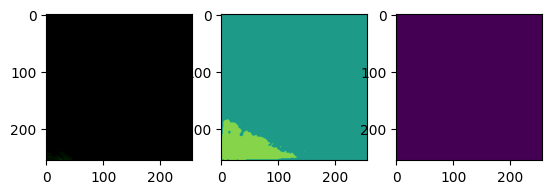

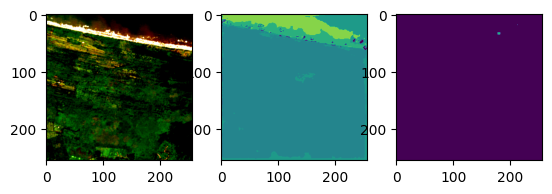

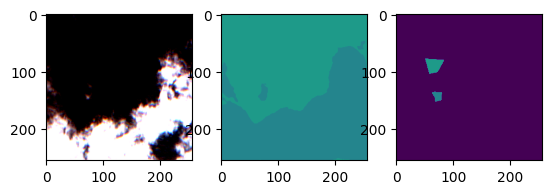

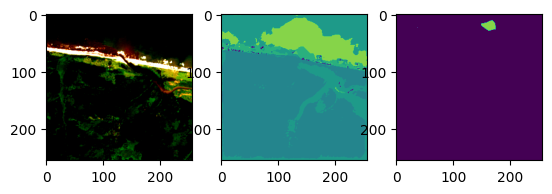

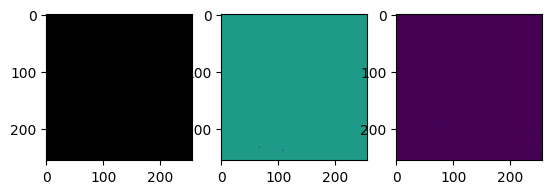

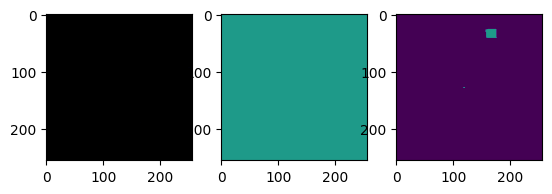

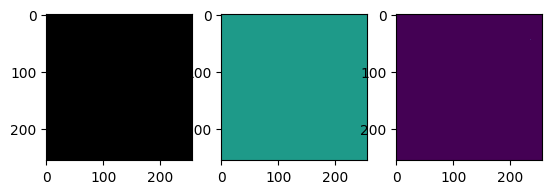

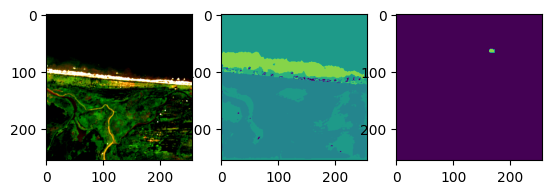

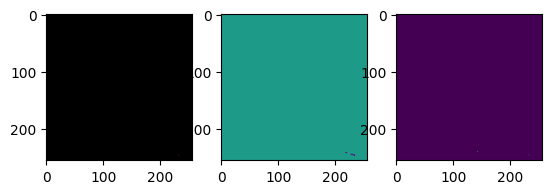

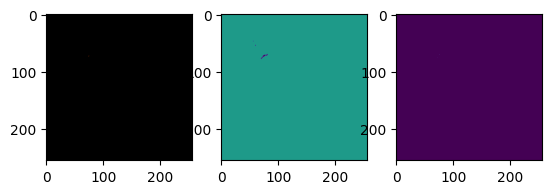

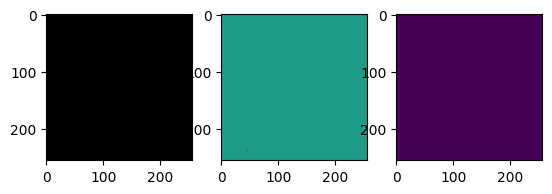

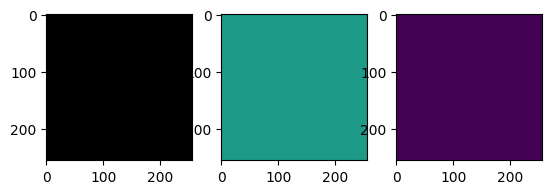

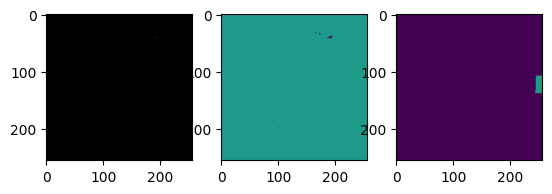

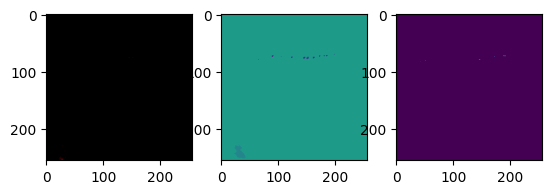

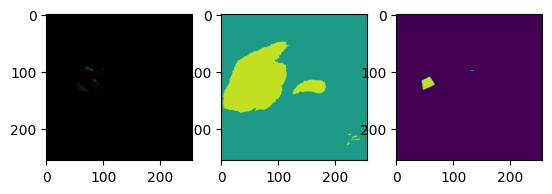

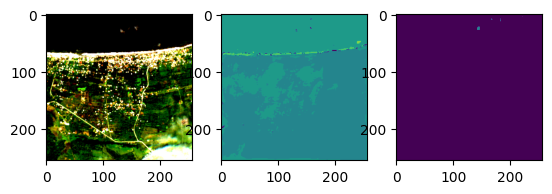

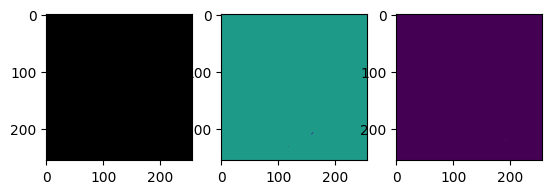

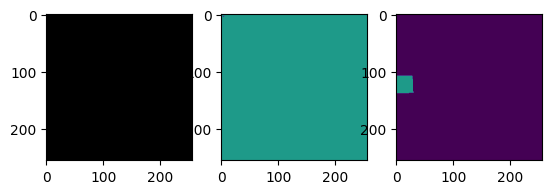

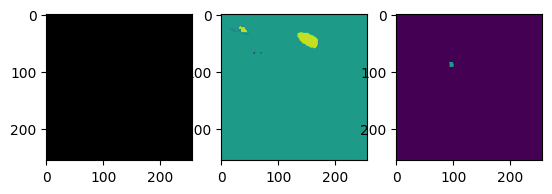

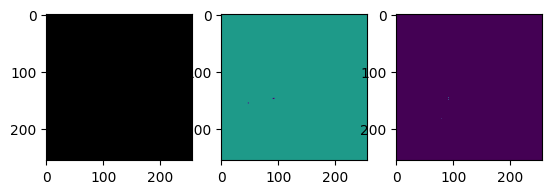

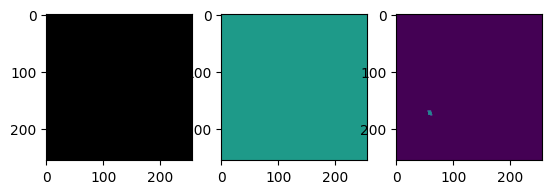

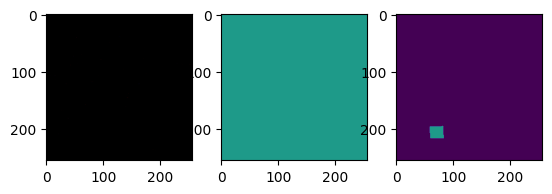

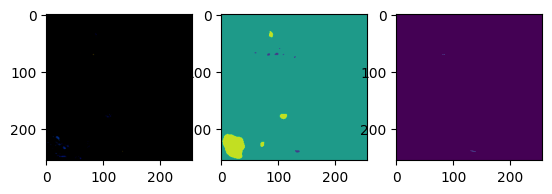

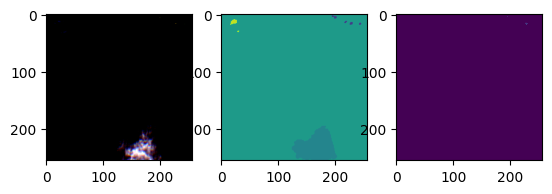

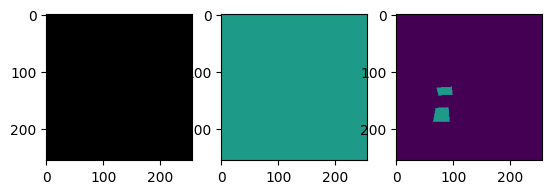

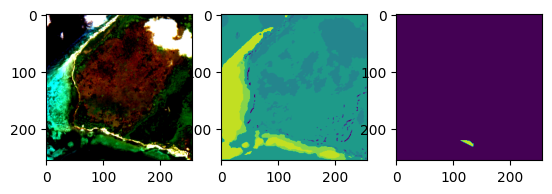

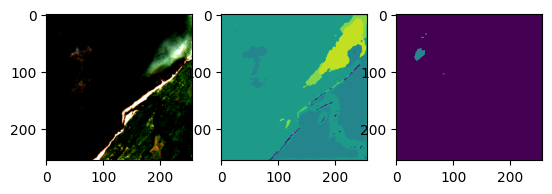

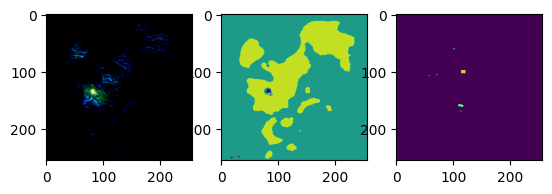

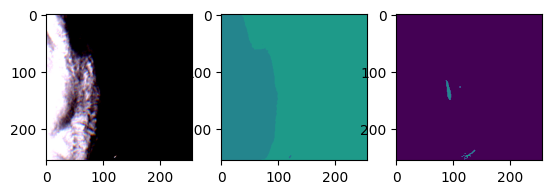

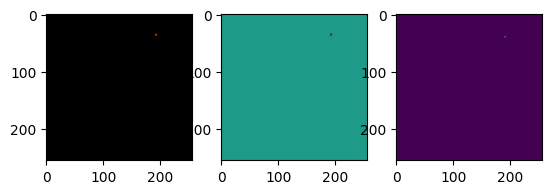

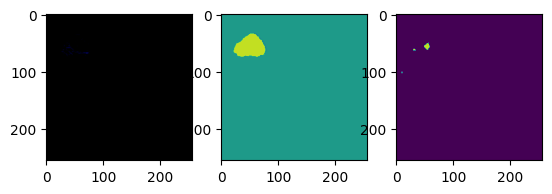

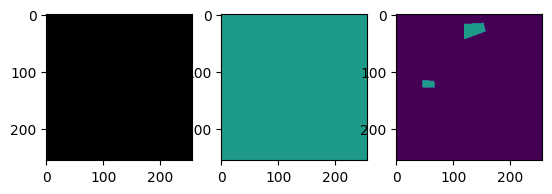

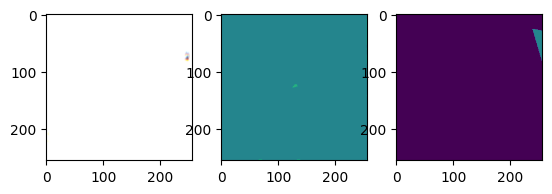

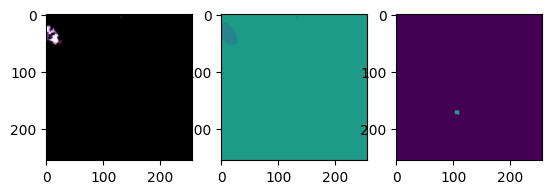

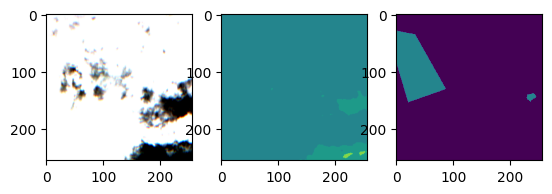

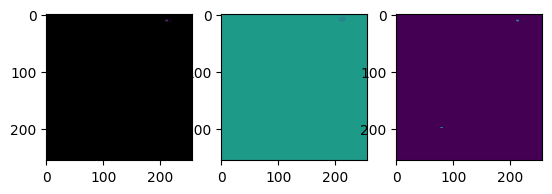

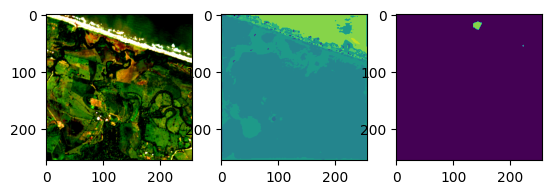

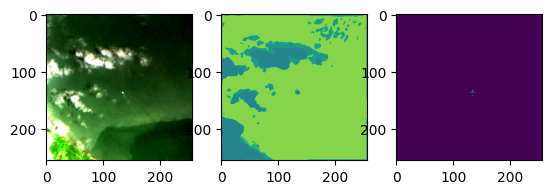

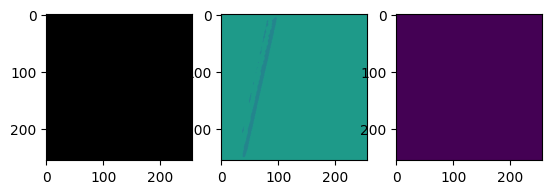

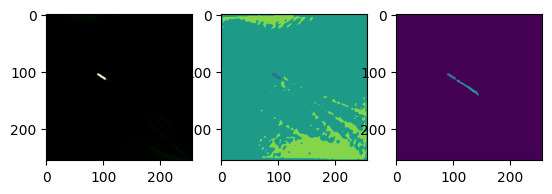

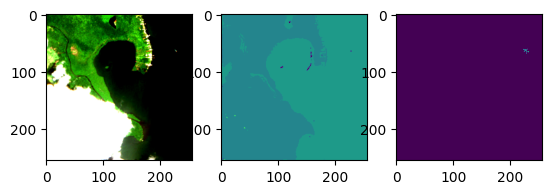

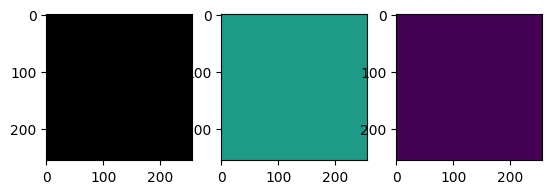

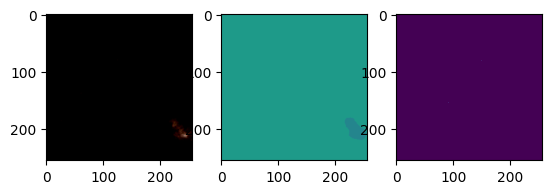

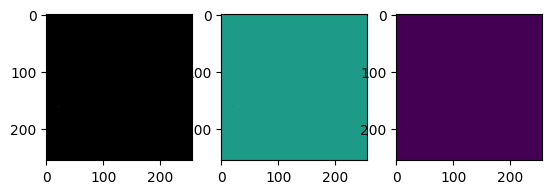

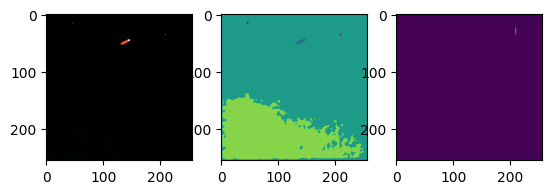

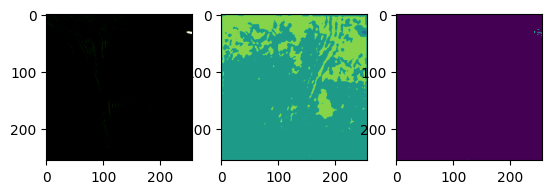

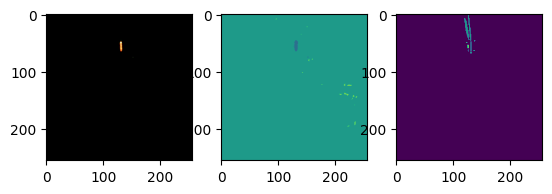

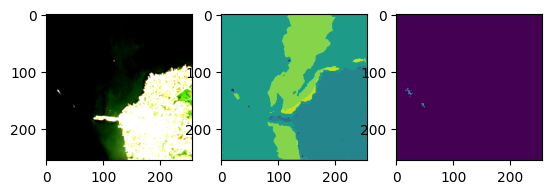

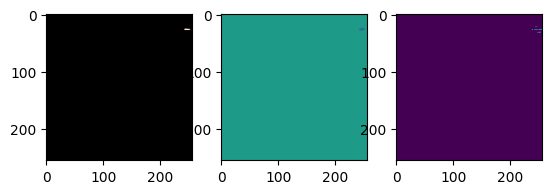

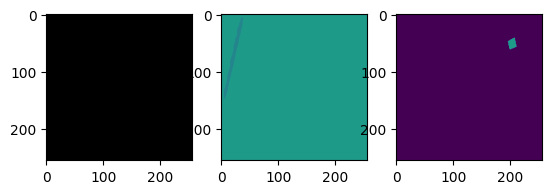

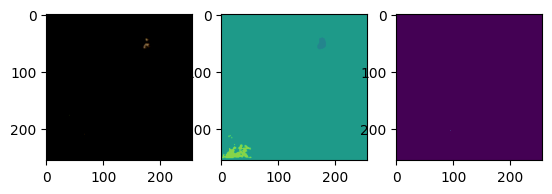

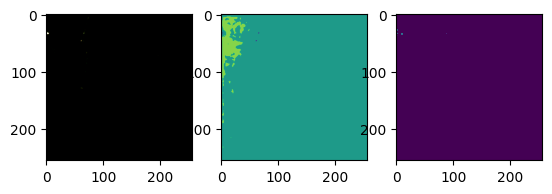

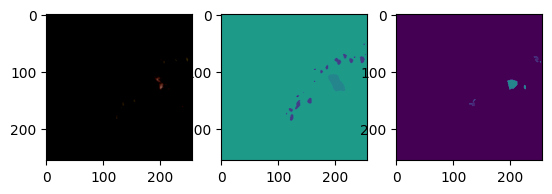

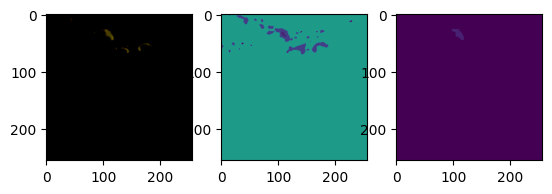

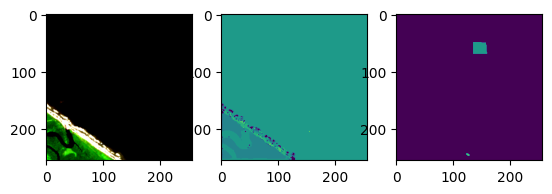

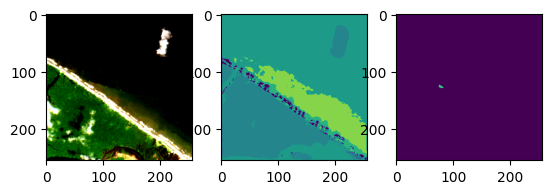

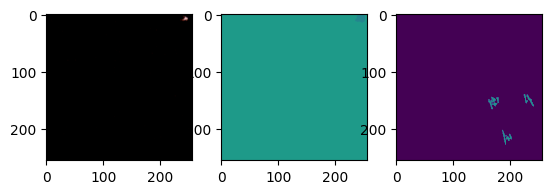

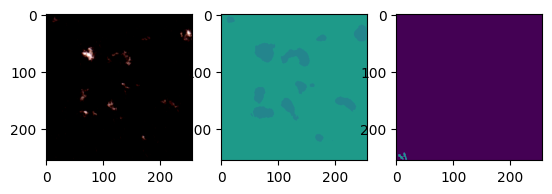

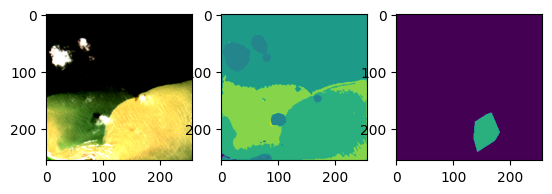

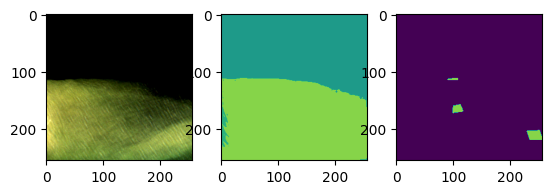

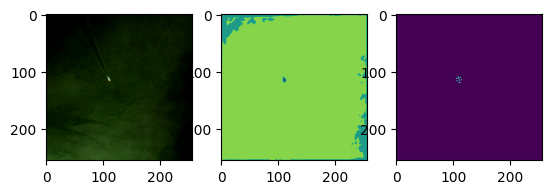

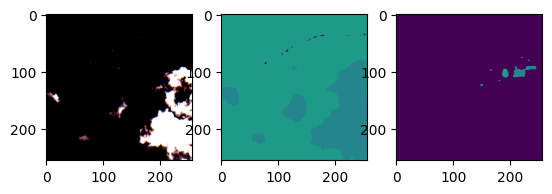

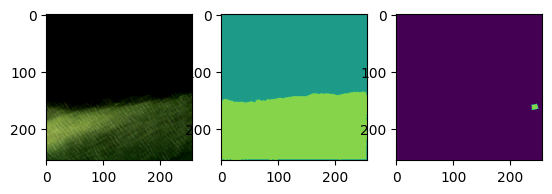

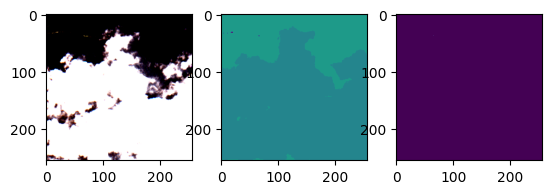

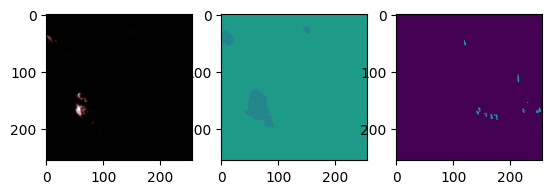

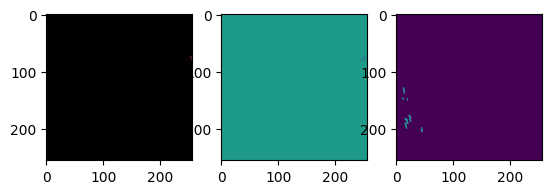

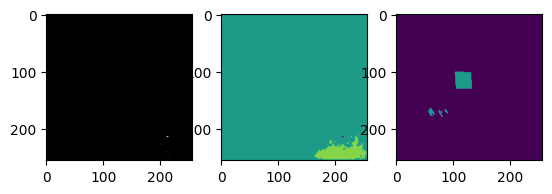

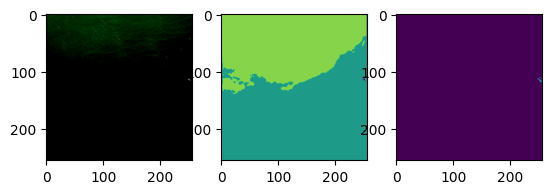

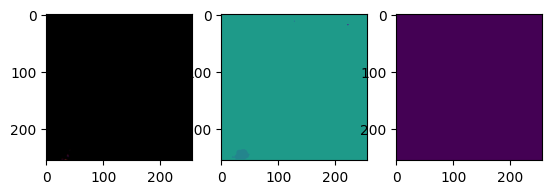

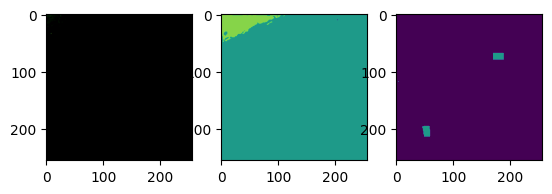

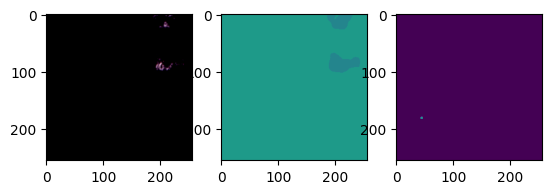

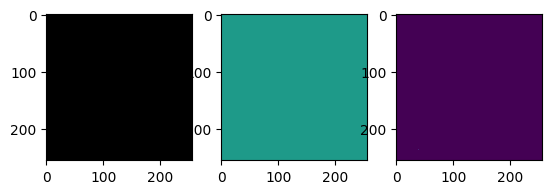

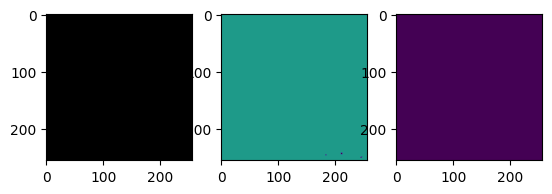

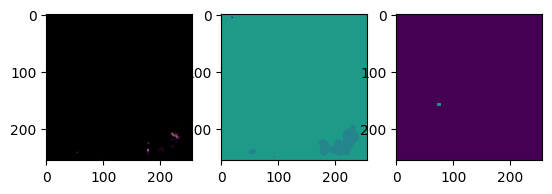

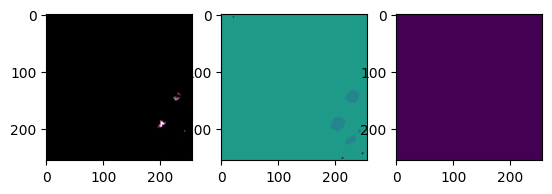

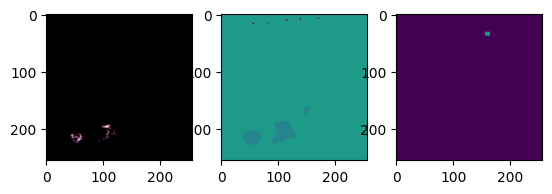

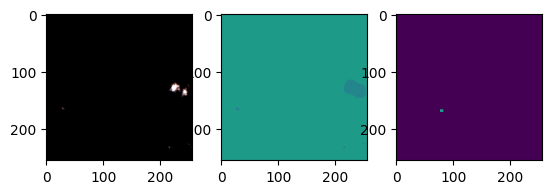

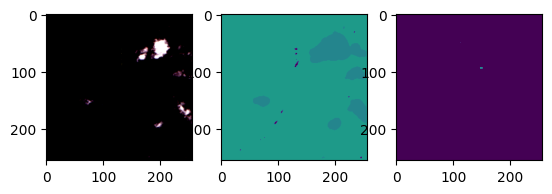

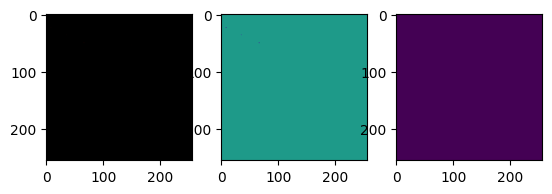

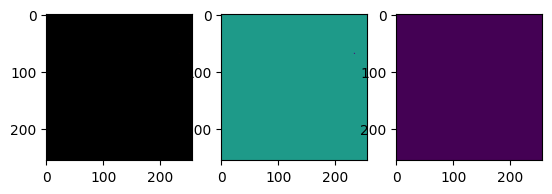

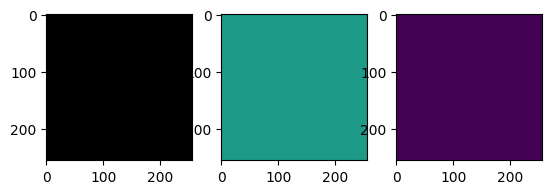

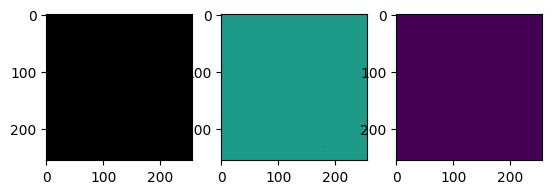

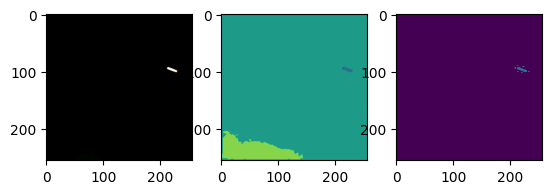

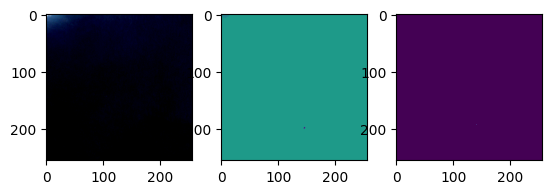

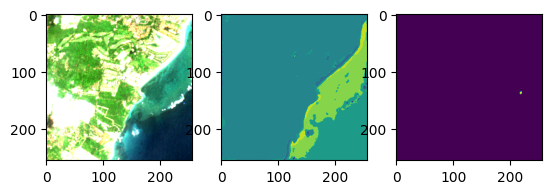

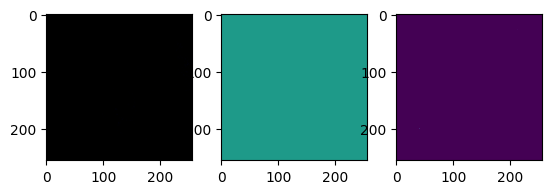

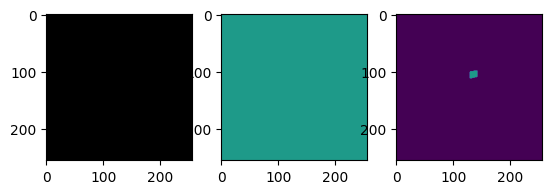

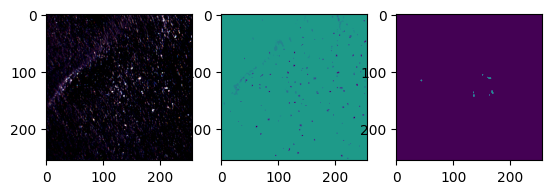

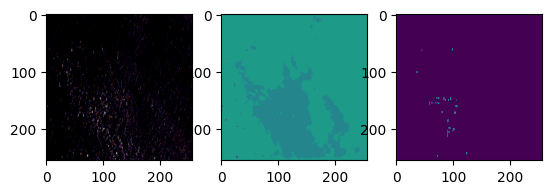

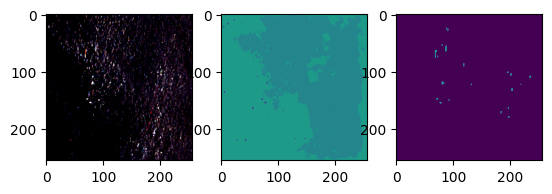

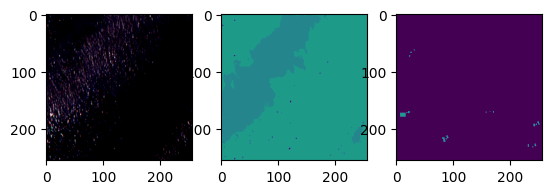

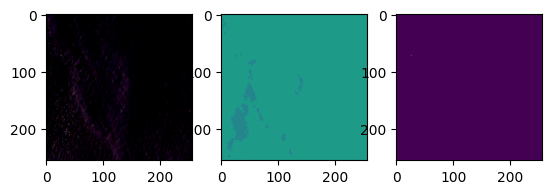

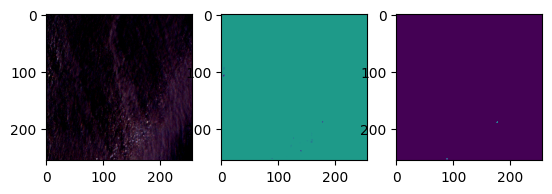

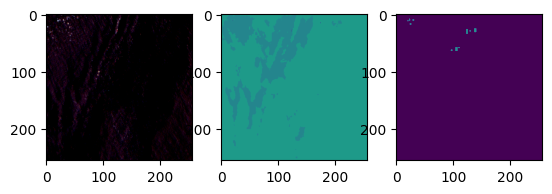

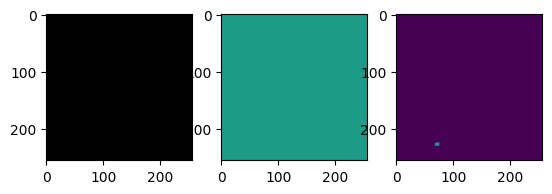

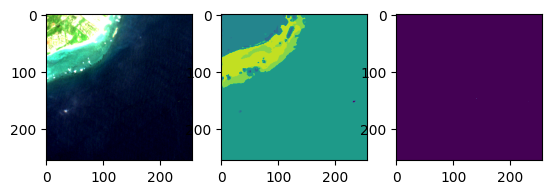

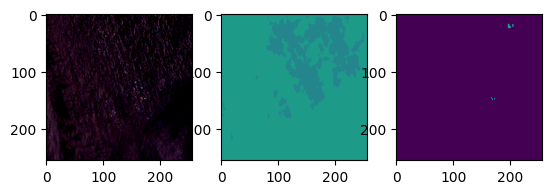

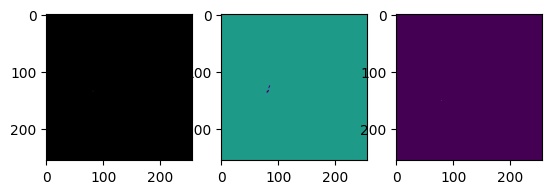

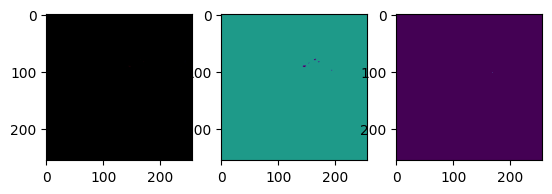

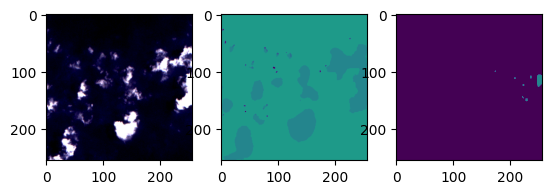

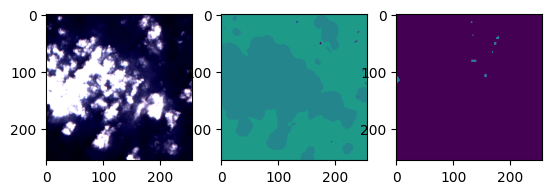

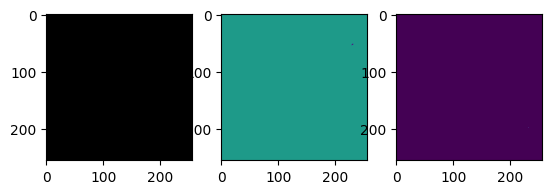

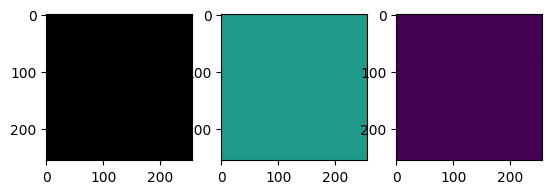

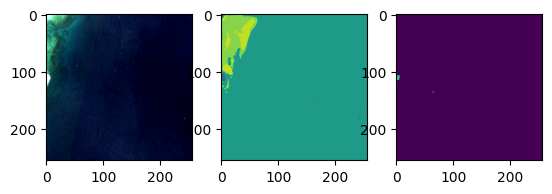

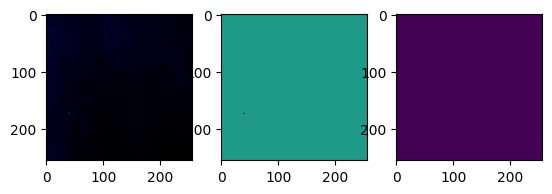

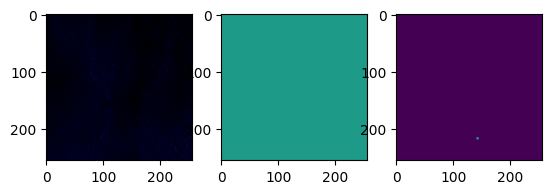

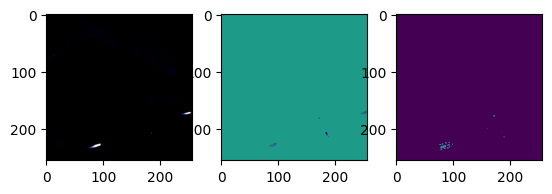

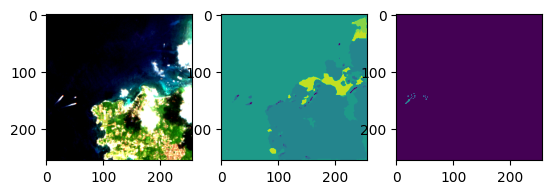

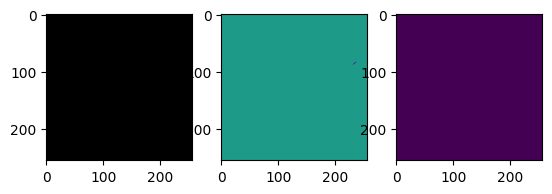

In [43]:
dataset_test = GenDEBRIS('test', transform=transform_test, standardization=standardization, agg_to_water=options['agg_to_water'])

test_loader = DataLoader(dataset_test,
                        batch_size=1,
                        shuffle=False,
                        num_workers=options['num_workers'],
                        pin_memory=options['pin_memory'],
                        prefetch_factor=options['prefetch_factor'],
                        persistent_workers=options['persistent_workers'],
                        worker_init_fn=seed_worker,
                        generator=g)

model.eval()

test_loss = []
test_batches = 0
y_true = []
y_predicted = []

# Define class names for better readability

class_names = {0: 'Marine Debris', 
1: 'Dense Sargassum',
2: 'Sparse Sargassum',
3: 'Natural Organic Material',
4: 'Ship',
5: 'Clouds',
6: 'Water',
7: 'Sediment-Laden Water',
8: 'Foam',
9: 'Turbid Water',
10: 'Shallow Water'} 

with torch.no_grad():
    for (image, target) in tqdm(test_loader, desc="testing"):
        image = image.to(device)
        target = target.to(device)

        logits_ = model(image)
        
        # Visualization
        plt.figure()
        plt.subplot(1, 3, 1), plt.imshow(np.squeeze(image.permute(0, 2, 3, 1).detach().cpu()[:, :, :, [3, 2, 1]]))
        plt.subplot(1, 3, 2), plt.imshow(np.squeeze(torch.argmax(logits_, 1).detach().cpu()), cmap='viridis', clim=[0, 11])
        plt.subplot(1, 3, 3), plt.imshow(np.squeeze(target.detach().cpu()), cmap='viridis', clim=[0, 11])

        loss = criterion(logits_, target)

        # Accuracy metrics only on annotated pixels
        logits = torch.movedim(logits_, (0, 1, 2, 3), (0, 3, 1, 2))
        logits = logits.reshape((-1, options['output_channels']))
        target = target.reshape(-1)
        mask = target != -1
        logits = logits[mask]
        target = target[mask]

        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
        target = target.cpu().numpy()

        test_batches += target.shape[0]
        test_loss.append((loss.data * target.shape[0]).tolist())
        y_predicted += probs.argmax(1).tolist()
        y_true += target.tolist()

    y_predicted = np.asarray(y_predicted)
    y_true = np.asarray(y_true)

    ####################################################################
    # Save Scores to the .log file                                     #
    ####################################################################
    acc = Evaluation(y_predicted, y_true)
    logging.info("\n")
    logging.info("Test loss was: " + str(sum(test_loss) / test_batches))
    logging.info("STATISTICS: \n")
    logging.info("Evaluation: " + str(acc))

    # Print results to the console
    print(f"Test loss was: {sum(test_loss) / test_batches}")
    print("STATISTICS: \n")
    print(f"Evaluation: {acc}")
    # Get unique classes in y_true
    unique_classes = np.unique(y_true)
    print(unique_classes)
    # Store accuracy per class
    class_accuracies = {}

    for cls in unique_classes:
        cls_mask = (y_true == cls)  # Get indices for this class
        correct = np.sum((y_predicted[cls_mask] == cls))  # Count correct predictions
        total = np.sum(cls_mask)  # Count total occurrences of this class

        if total > 0:  # Avoid division by zero
            class_accuracies[cls] = correct / total

    # Find most and least accurate classes
    most_accurate_class = max(class_accuracies, key=class_accuracies.get)
    least_accurate_class = min(class_accuracies, key=class_accuracies.get)

    # Print per-class accuracies
    print("\n📊 Per-Class Accuracy:")
    for cls, acc in class_accuracies.items():
        class_name = class_names.get(cls, f"Class {cls}")
        print(f"{class_name}: {acc:.4f}")

    print(f"\n✅ Most Accurate Class: {class_names.get(most_accurate_class, 'Unknown')} ({class_accuracies[most_accurate_class]:.4f})")
    print(f"⚠️ Least Accurate Class: {class_names.get(least_accurate_class, 'Unknown')} ({class_accuracies[least_accurate_class]:.4f})")


